In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import files
import io

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"Загружен файл: {filename}")

df = pd.read_csv(io.BytesIO(uploaded[filename]))
print("Данные успешно загружены")

Saving Hospitalization_Rate_Related_To_Alzheimer_s_Or_Other_Dementias_2008-2017.csv to Hospitalization_Rate_Related_To_Alzheimer_s_Or_Other_Dementias_2008-2017.csv
Загружен файл: Hospitalization_Rate_Related_To_Alzheimer_s_Or_Other_Dementias_2008-2017.csv
Данные успешно загружены


In [3]:
# Первичный осмотр данных
print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
display(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика числовых колонок:")
display(df.describe())

print("=== ПРОВЕРКА КАЧЕСТВА ДАННЫХ ===")
print("\nПропущенные значения:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({
    'Колонка': df.columns,
    'Пропущено': missing_data,
    'Процент': missing_percent
})
display(missing_info)

print("\nДубликаты:", df.duplicated().sum())

# Обработка пропусков
def handle_missing_data(df):
    df_clean = df.copy()

    # Для числовых колонок
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            # Заполняем медианой, если есть выбросы, иначе средним
            if df_clean[col].skew() > 2:
                df_clean[col].fillna(df_clean[col].median(), inplace=True)
            else:
                df_clean[col].fillna(df_clean[col].mean(), inplace=True)

    # Для категориальных колонок
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].mode()[0], inplace=True)

    return df_clean

df_clean = handle_missing_data(df)
print("Обработка пропусков завершена!")

Размер датасета: (1250, 5)

Первые 5 строк:


,Jurisdiction,Value,Race/ ethnicity,Year,Measure
0,State,515.5,All races (aggregated),2017,Alzheimers Hospitalization
1,Allegany,704.7,All races (aggregated),2017,Alzheimers Hospitalization
2,Anne Arundel,474.8,All races (aggregated),2017,Alzheimers Hospitalization
3,Baltimore City,820.2,All races (aggregated),2017,Alzheimers Hospitalization
4,Baltimore County,559.0,All races (aggregated),2017,Alzheimers Hospitalization



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Jurisdiction     1250 non-null   object 
 1   Value            646 non-null    float64
 2   Race/ ethnicity  1250 non-null   object 
 3   Year             1250 non-null   int64  
 4   Measure          1250 non-null   object 
dtypes: float64(1), int64(1), object(3)
memory usage: 49.0+ KB
None

Статистика числовых колонок:


,Value,Year
count,646.000000,1250.000000
mean,324.562384,2012.500000
std,169.615826,2.873431
min,33.400000,2008.000000
25%,204.200000,2010.000000
50%,291.050000,2012.500000
75%,407.300000,2015.000000
max,1259.600000,2017.000000


=== ПРОВЕРКА КАЧЕСТВА ДАННЫХ ===

Пропущенные значения:


,Колонка,Пропущено,Процент
Jurisdiction,Jurisdiction,0,0.00
Value,Value,604,48.32
Race/ ethnicity,Race/ ethnicity,0,0.00
Year,Year,0,0.00
Measure,Measure,0,0.00



Дубликаты: 0
Обработка пропусков завершена!


=== ДЕТАЛЬНЫЙ EDA АНАЛИЗ ===


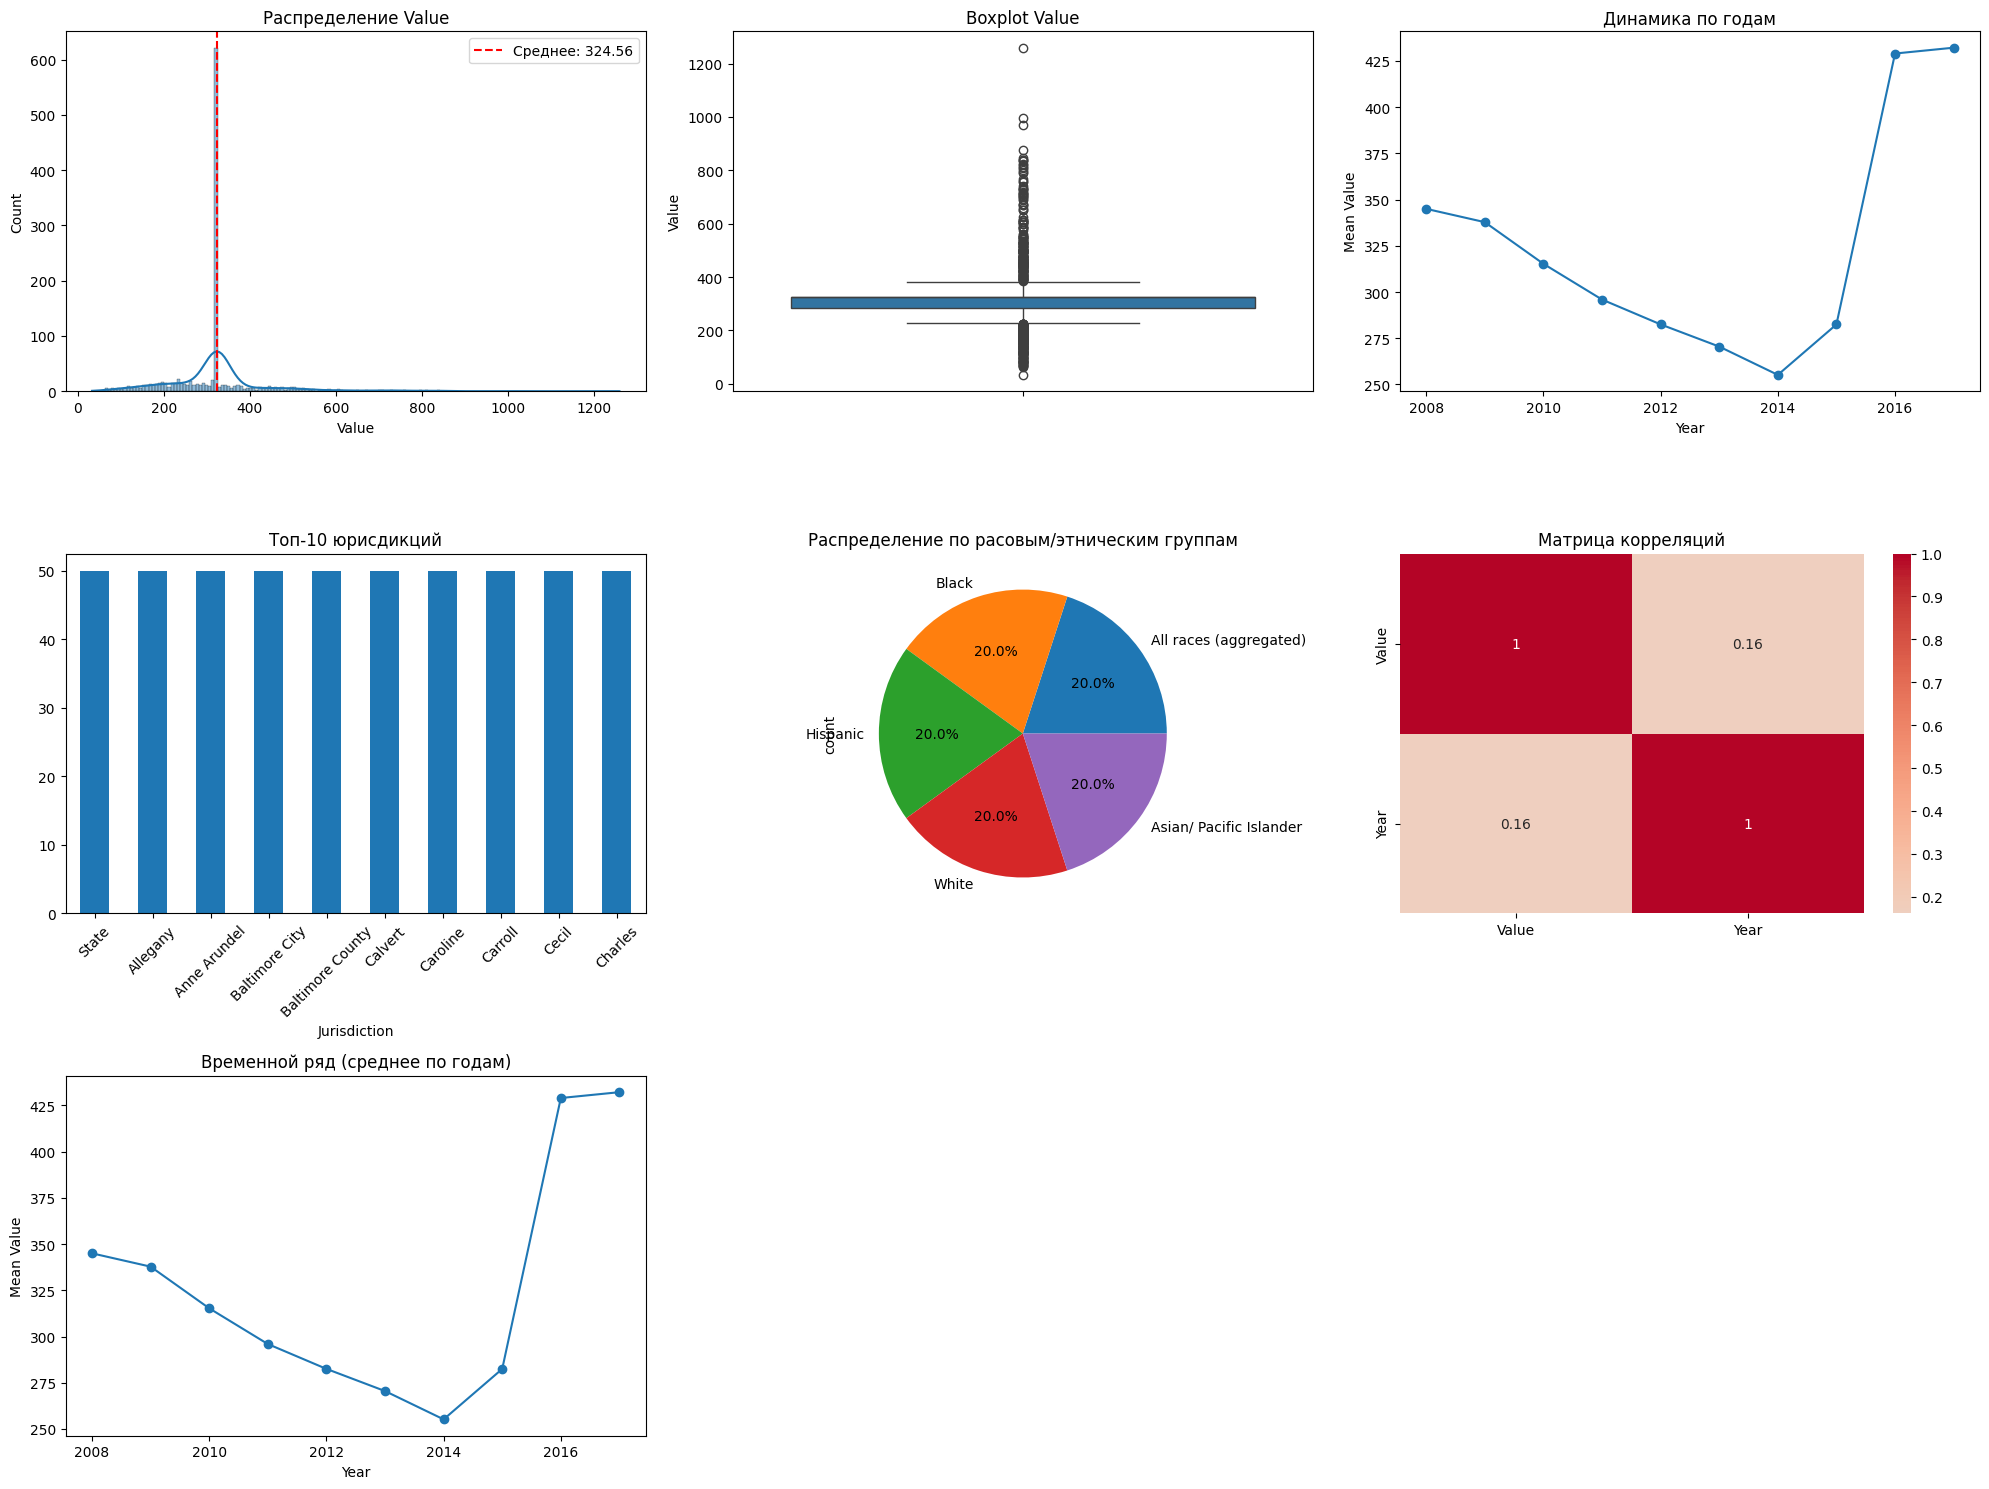

In [10]:
print("=== ДЕТАЛЬНЫЙ EDA АНАЛИЗ ===")
import seaborn as sns
# подграфики
fig = plt.figure(figsize=(20, 15))

# 1. Распределение числовых значений
plt.subplot(3, 3, 1)
if 'Value' in df_clean.columns:
    sns.histplot(df_clean['Value'], kde=True)
    plt.title('Распределение Value')
    plt.axvline(df_clean['Value'].mean(), color='r', linestyle='--', label=f'Среднее: {df_clean["Value"].mean():.2f}')
    plt.legend()

# 2. Boxplot для выявления выбросов
plt.subplot(3, 3, 2)
if 'Value' in df_clean.columns:
    sns.boxplot(y=df_clean['Value'])
    plt.title('Boxplot Value')

# 3. Анализ по годам
plt.subplot(3, 3, 3)
if 'Year' in df_clean.columns:
    yearly_data = df_clean.groupby('Year')['Value'].mean() if 'Value' in df_clean.columns else df_clean.groupby('Year').size()
    yearly_data.plot(kind='line', marker='o')
    plt.title('Динамика по годам')
    plt.xlabel('Year')
    plt.ylabel('Mean Value' if 'Value' in df_clean.columns else 'Count')

# 4. Анализ по юрисдикциям
plt.subplot(3, 3, 4)
if 'Jurisdiction' in df_clean.columns:
    jur_data = df_clean['Jurisdiction'].value_counts().head(10)
    jur_data.plot(kind='bar')
    plt.title('Топ-10 юрисдикций')
    plt.xticks(rotation=45)

# 5. Анализ по расовым/этническим группам
plt.subplot(3, 3, 5)
if 'Race/ ethnicity' in df_clean.columns:
    race_data = df_clean['Race/ ethnicity'].value_counts()
    race_data.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Распределение по расовым/этническим группам')

# 6. Heatmap корреляций
plt.subplot(3, 3, 6)
numeric_df = df_clean.select_dtypes(include=[np.number])
if len(numeric_df.columns) > 1:
    sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Матрица корреляций')

# 7. Анализ временного ряда
plt.subplot(3, 3, 7)
if 'Year' in df_clean.columns and 'Value' in df_clean.columns:
    time_series = df_clean.groupby('Year')['Value'].mean()
    plt.plot(time_series.index, time_series.values, marker='o')
    plt.title('Временной ряд (среднее по годам)')
    plt.xlabel('Year')
    plt.ylabel('Mean Value')

plt.tight_layout()
plt.show()

import plotly.express as px
# 3. 3D scatter plot
if all(col in df_clean.columns for col in ['Year', 'Value', 'Jurisdiction']):
    fig = px.scatter_3d(df_clean, x='Year', y='Value', z='Jurisdiction',
                        color='Value', title='3D визуализация данных')
    fig.show()

=== ПОДГОТОВКА ДАННЫХ ДЛЯ ВРЕМЕННЫХ РЯДОВ ===
Временной ряд создан:
Период: 2008-01-01 00:00:00 - 2017-01-01 00:00:00
Длина ряда: 10


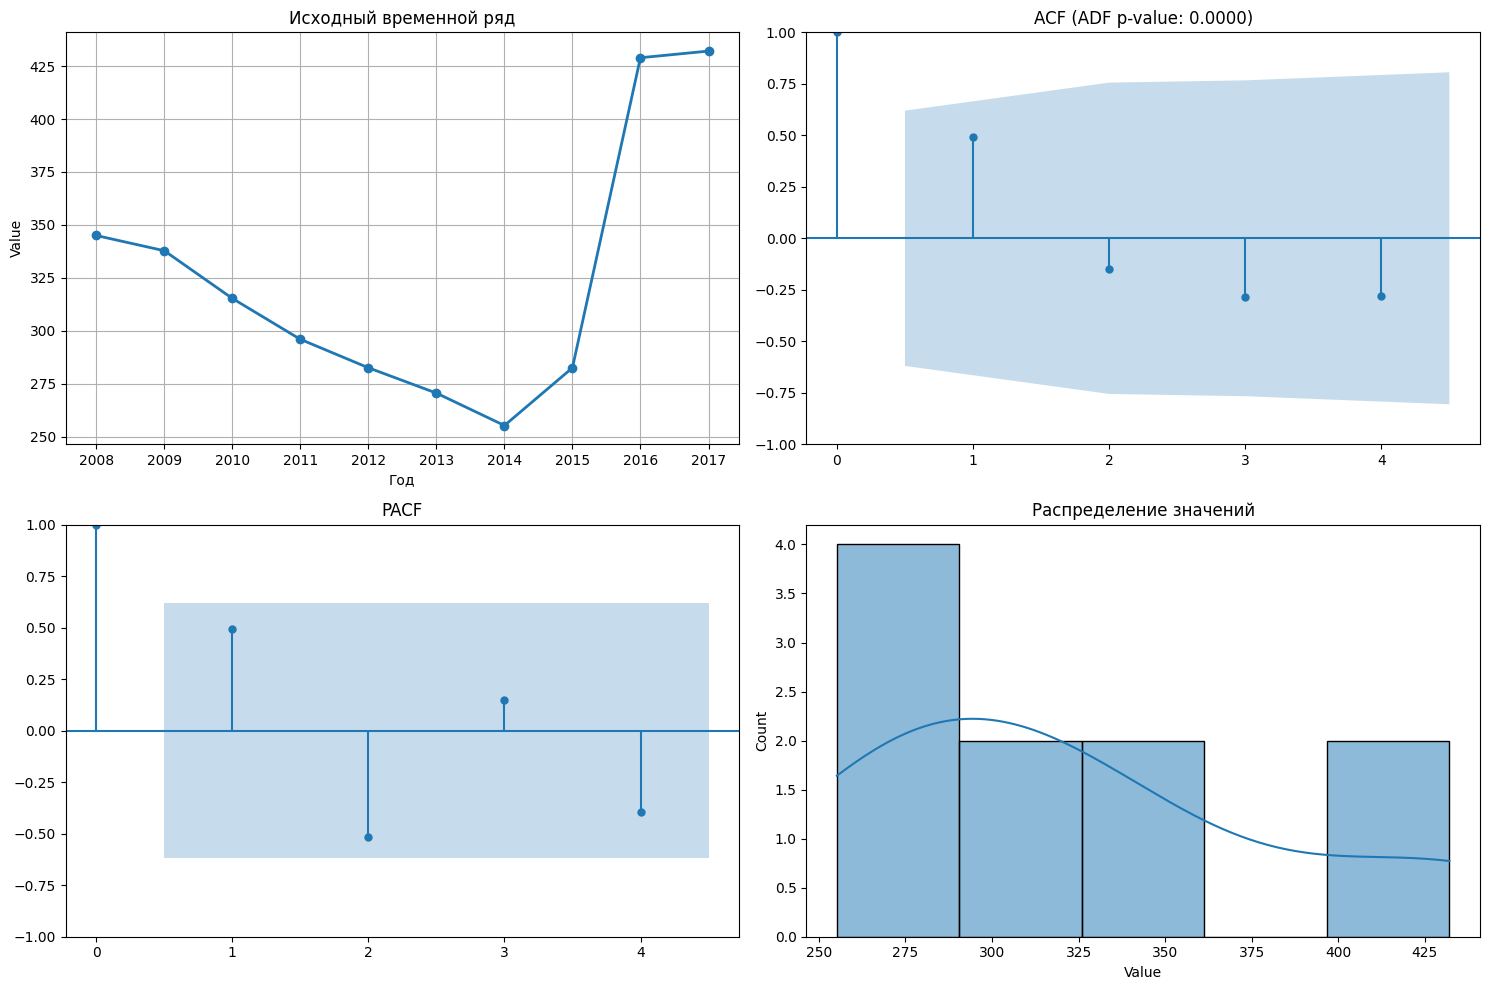

Результат теста Дики-Фуллера: p-value = 0.0000
Ряд стационарен (отвергаем H0)


In [11]:
# Подготовка данных для временных рядов
print("=== ПОДГОТОВКА ДАННЫХ ДЛЯ ВРЕМЕННЫХ РЯДОВ ===")

# Создаем агрегированный временной ряд (среднее по всем группам)
if 'Year' in df_clean.columns and 'Value' in df_clean.columns:
    time_series = df_clean.groupby('Year')['Value'].mean().sort_index()

    # Преобразуем в правильный формат временного ряда
    time_series.index = pd.to_datetime(time_series.index, format='%Y')
    time_series = time_series.asfreq('YS')  # Year Start frequency

    print("Временной ряд создан:")
    print(f"Период: {time_series.index.min()} - {time_series.index.max()}")
    print(f"Длина ряда: {len(time_series)}")

    # Визуализация исходного временного ряда
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(time_series.index, time_series.values, marker='o', linewidth=2)
    plt.title('Исходный временной ряд')
    plt.xlabel('Год')
    plt.ylabel('Value')
    plt.grid(True)

    # Тест на стационарность
    plt.subplot(2, 2, 2)
    result = adfuller(time_series.dropna())
    plot_acf(time_series, ax=plt.gca(), lags=min(10, len(time_series)//2-1))
    plt.title(f'ACF (ADF p-value: {result[1]:.4f})')

    plt.subplot(2, 2, 3)
    plot_pacf(time_series, ax=plt.gca(), lags=min(10, len(time_series)//2-1))
    plt.title('PACF')

    plt.subplot(2, 2, 4)
    sns.histplot(time_series, kde=True)
    plt.title('Распределение значений')

    plt.tight_layout()
    plt.show()

    print(f"Результат теста Дики-Фуллера: p-value = {result[1]:.4f}")
    if result[1] <= 0.05:
        print("Ряд стационарен (отвергаем H0)")
    else:
        print("Ряд нестационарен (не можем отвергнуть H0)")
else:
    print("Ошибка: Отсутствуют необходимые колонки 'Year' или 'Value'")
    time_series = None

=== ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА ===


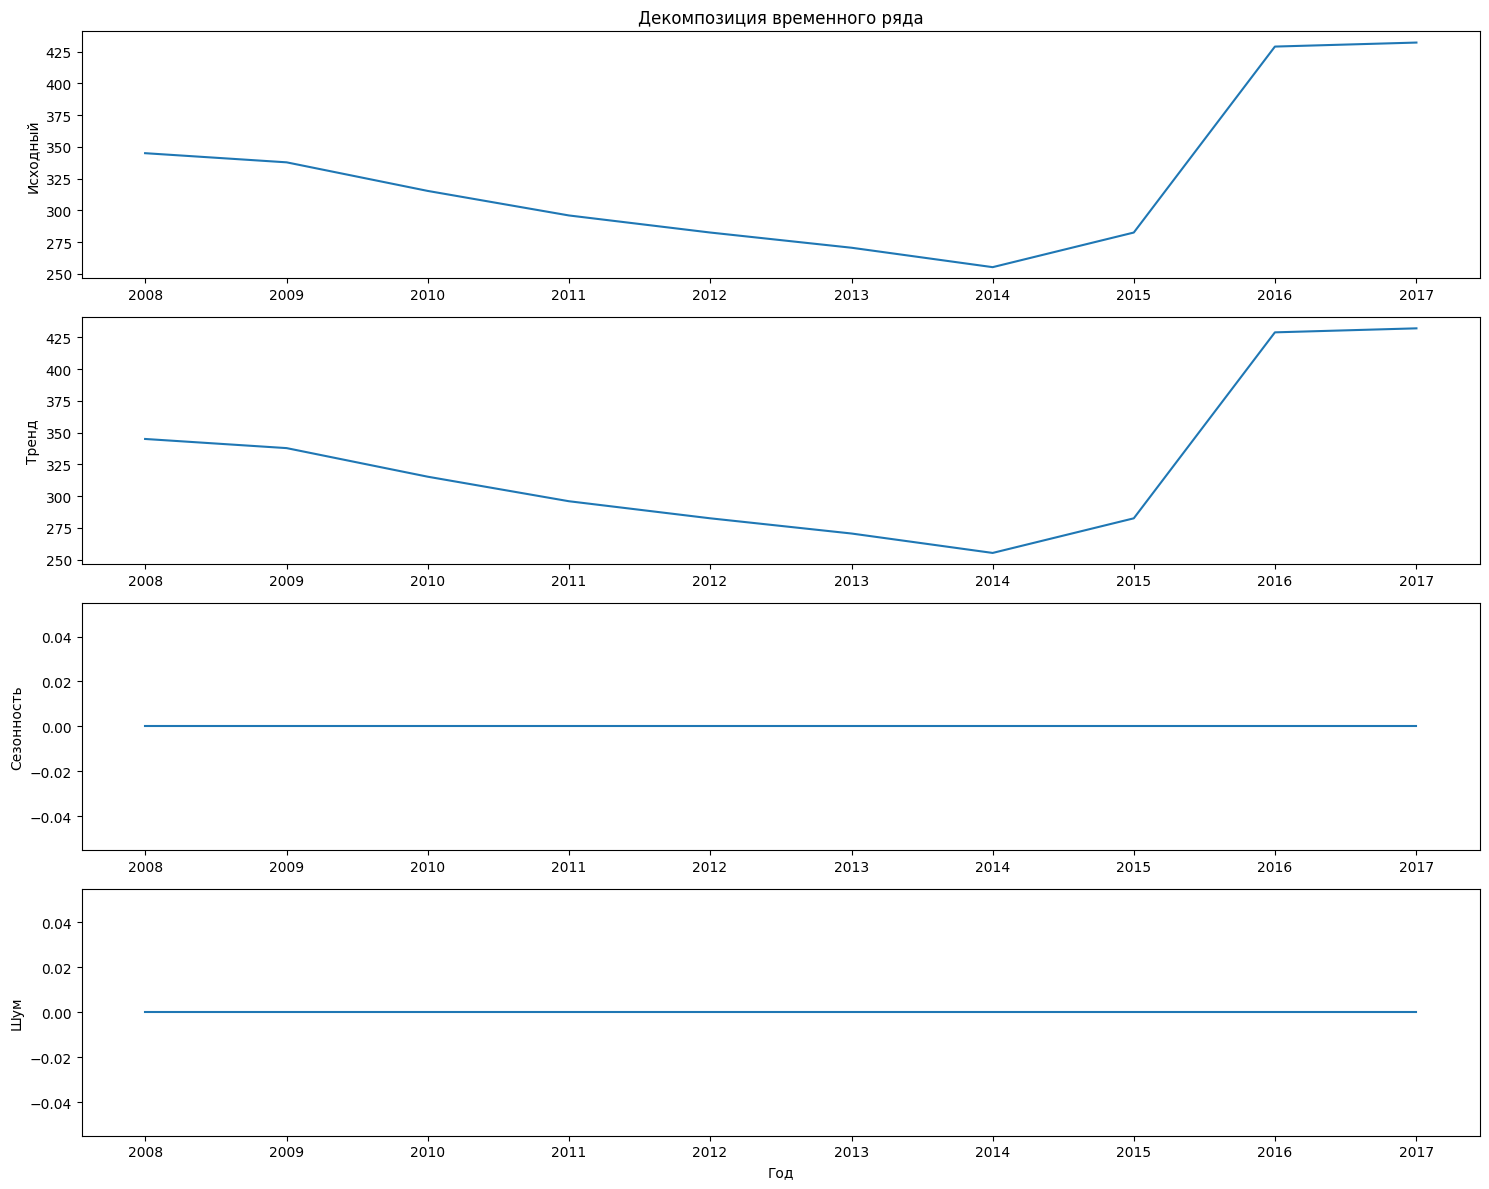

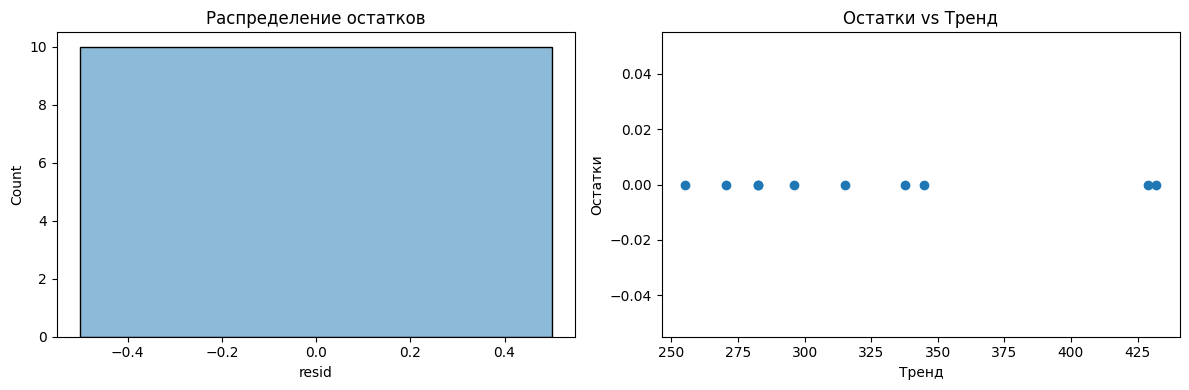

In [13]:
# Декомпозиция временного ряда
print("=== ДЕКОМПОЗИЦИЯ ВРЕМЕННОГО РЯДА ===")
from statsmodels.tsa.seasonal import seasonal_decompose
if time_series is not None:
    # Декомпозиция с использованием разных методов
    decomposition = seasonal_decompose(time_series, model='additive', period=1)  # Для годовых данных период=1

    fig, axes = plt.subplots(4, 1, figsize=(15, 12))

    # Исходный ряд
    axes[0].plot(time_series.index, time_series.values)
    axes[0].set_ylabel('Исходный')
    axes[0].set_title('Декомпозиция временного ряда')

    # Тренд
    axes[1].plot(time_series.index, decomposition.trend)
    axes[1].set_ylabel('Тренд')

    # Сезонность (для годовых данных может отсутствовать)
    axes[2].plot(time_series.index, decomposition.seasonal)
    axes[2].set_ylabel('Сезонность')

    # Шум (остатки)
    axes[3].plot(time_series.index, decomposition.resid)
    axes[3].set_ylabel('Шум')
    axes[3].set_xlabel('Год')

    plt.tight_layout()
    plt.show()

    # Анализ остатков
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(decomposition.resid.dropna(), kde=True)
    plt.title('Распределение остатков')

    plt.subplot(1, 2, 2)
    plt.scatter(decomposition.trend, decomposition.resid)
    plt.xlabel('Тренд')
    plt.ylabel('Остатки')
    plt.title('Остатки vs Тренд')

    plt.tight_layout()
    plt.show()

=== ПРЕДОБРАБОТКА И СОЗДАНИЕ ПРИЗНАКОВ ===
Созданные признаки:


,value,lag_1,lag_2,lag_3,rolling_mean_3,rolling_std_3,rolling_min_3,rolling_max_3,year,time_idx
Year,,,,,,,,,,
2011-01-01,295.927742,315.244344,337.766245,344.973643,316.312777,20.939705,295.927742,337.766245,2011,3
2012-01-01,282.492440,295.927742,315.244344,337.766245,297.888175,16.463726,282.492440,315.244344,2012,4
2013-01-01,270.497841,282.492440,295.927742,315.244344,282.972675,12.721750,270.497841,295.927742,2013,5
2014-01-01,255.198539,270.497841,282.492440,295.927742,269.396273,13.680254,255.198539,282.492440,2014,6
2015-01-01,282.467742,255.198539,270.497841,282.492440,269.388041,13.668435,255.198539,282.467742,2015,7


Train size: 5, Test size: 2


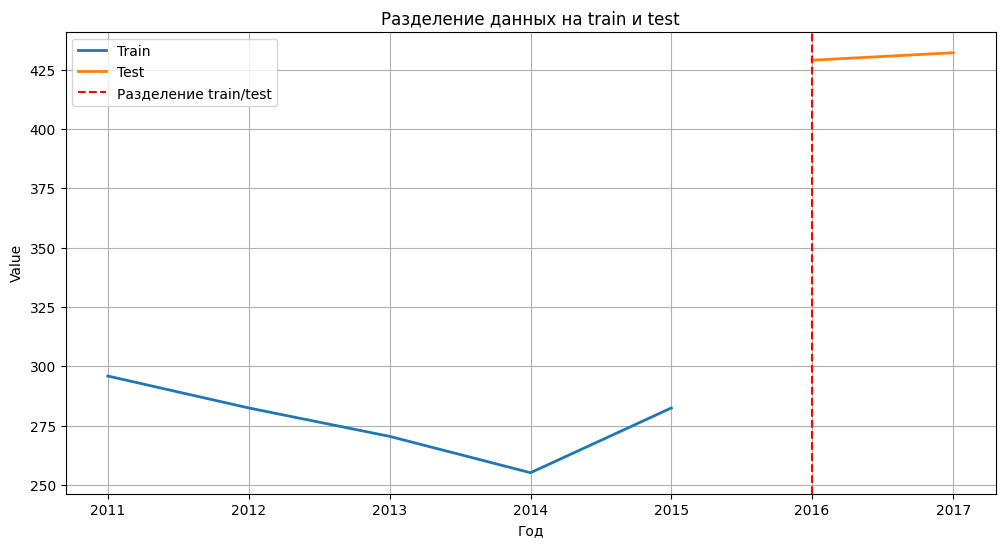

In [14]:
# Предобработка и создание признаков для временных рядов
print("=== ПРЕДОБРАБОТКА И СОЗДАНИЕ ПРИЗНАКОВ ===")
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
def create_features_for_time_series(series, lags=3):
    # Создает дополнительные признаки для временного ряда
    df_features = pd.DataFrame({'value': series})
    df_features.index = series.index

    # Лаговые признаки
    for i in range(1, lags + 1):
        df_features[f'lag_{i}'] = df_features['value'].shift(i)

    # Скользящие статистики
    df_features['rolling_mean_3'] = df_features['value'].rolling(window=3).mean()
    df_features['rolling_std_3'] = df_features['value'].rolling(window=3).std()
    df_features['rolling_min_3'] = df_features['value'].rolling(window=3).min()
    df_features['rolling_max_3'] = df_features['value'].rolling(window=3).max()

    # Временные признаки
    df_features['year'] = df_features.index.year
    df_features['time_idx'] = range(len(df_features))

    return df_features.dropna()

if time_series is not None:
    # Создаем признаки
    features_df = create_features_for_time_series(time_series)

    print("Созданные признаки:")
    display(features_df.head())

    # Разделение на train/test
    train_size = int(len(features_df) * 0.8)
    train = features_df.iloc[:train_size]
    test = features_df.iloc[train_size:]

    # Масштабирование
    scaler = StandardScaler()
    scaler.fit(train[['value']])

    train_scaled = train.copy()
    test_scaled = test.copy()
    train_scaled['value'] = scaler.transform(train[['value']])
    test_scaled['value'] = scaler.transform(test[['value']])

    print(f"Train size: {len(train)}, Test size: {len(test)}")

    # Визуализация разделения
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['value'], label='Train', linewidth=2)
    plt.plot(test.index, test['value'], label='Test', linewidth=2)
    plt.axvline(x=test.index[0], color='red', linestyle='--', label='Разделение train/test')
    plt.legend()
    plt.title('Разделение данных на train и test')
    plt.xlabel('Год')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

=== АНАЛИЗ РЕЗКОГО СКАЧКА В ДАННЫХ ===
Анализ изменений по годам:


,Year,Value,Absolute Change,Percent Change
0,2008,344.973643,NaN,NaN
1,2009,337.766245,-7.207398,-2.089261
2,2010,315.244344,-22.521901,-6.667896
3,2011,295.927742,-19.316602,-6.127501
4,2012,282.492440,-13.435303,-4.540062
5,2013,270.497841,-11.994598,-4.245989
6,2014,255.198539,-15.299303,-5.655980
7,2015,282.467742,27.269204,10.685486
8,2016,428.948851,146.481108,51.857641
9,2017,432.106451,3.157600,0.736125


  Обнаружен скачок в 2016:
   Абсолютное изменение: 146.48
   Процентное изменение: 51.9%


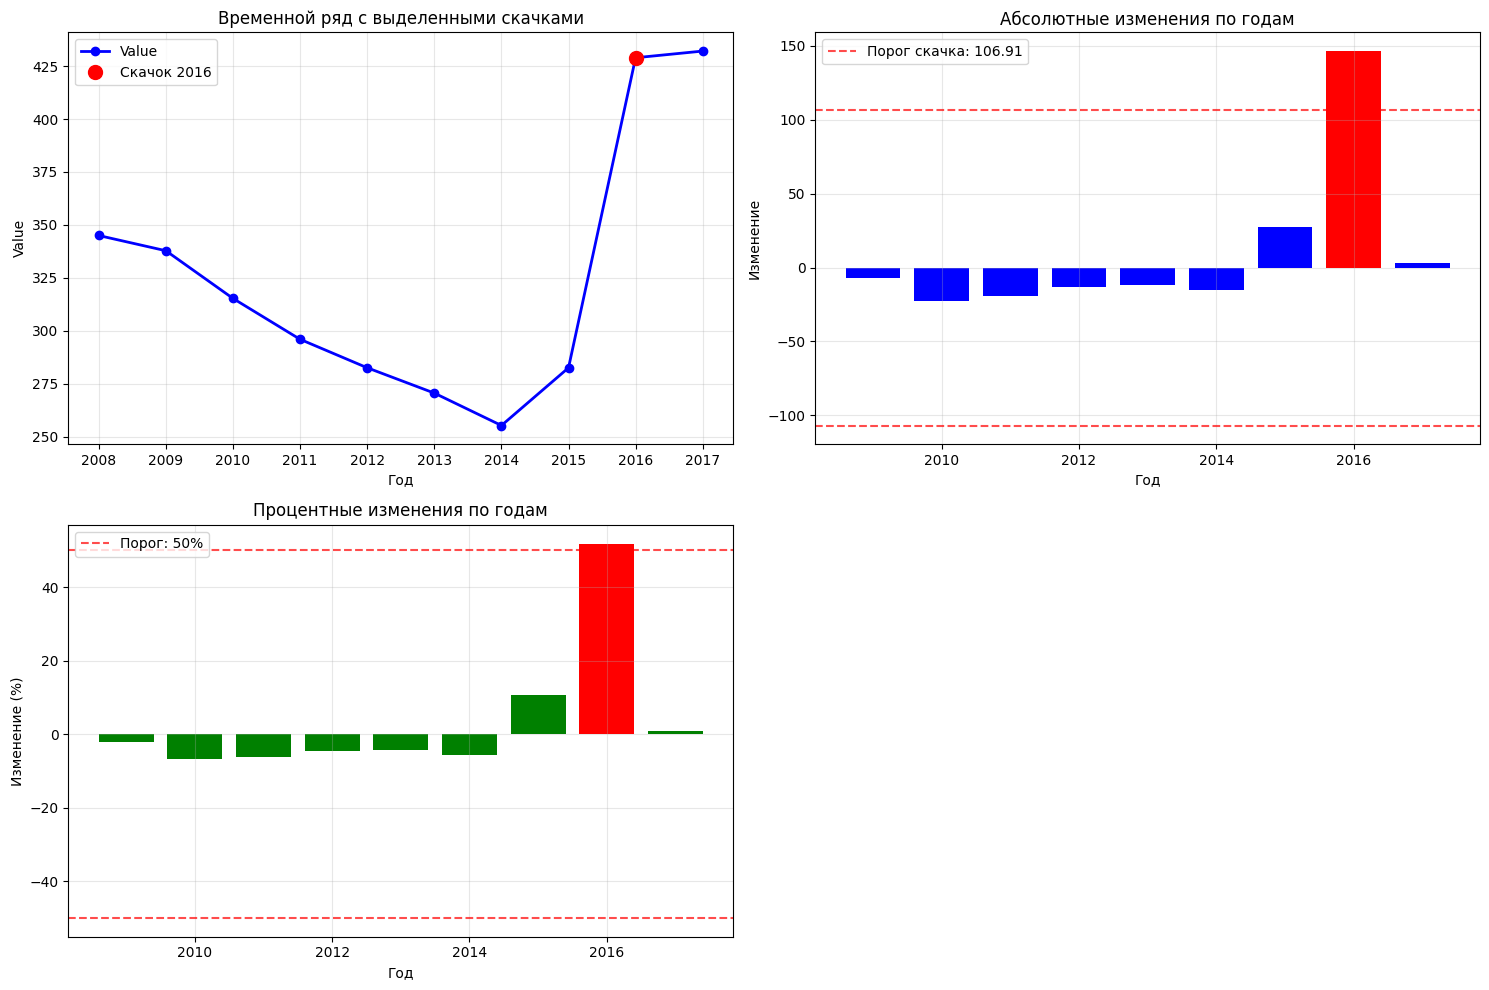

In [15]:
# Анализ скачка в данных и адаптивное разделение
print("=== АНАЛИЗ РЕЗКОГО СКАЧКА В ДАННЫХ ===")

if time_series is not None:
    # Анализируем изменения между годами
    changes = time_series.diff()
    pct_changes = time_series.pct_change() * 100

    print("Анализ изменений по годам:")
    analysis_df = pd.DataFrame({
        'Year': time_series.index.year,
        'Value': time_series.values,
        'Absolute Change': changes.values,
        'Percent Change': pct_changes.values
    })
    display(analysis_df)

    # Находим скачки
    threshold_abs = changes.std() * 2  # 2 стандартных отклонения
    threshold_pct = 50  # 50% изменение

    spikes_abs = abs(changes) > threshold_abs
    spikes_pct = abs(pct_changes) > threshold_pct

    spike_years = []
    for i, (year, abs_spike, pct_spike) in enumerate(zip(time_series.index.year[1:], spikes_abs[1:], spikes_pct[1:])):
        if abs_spike or pct_spike:
            spike_years.append(year)
            print(f"  Обнаружен скачок в {year}:")
            print(f"   Абсолютное изменение: {changes.iloc[i+1]:.2f}")
            print(f"   Процентное изменение: {pct_changes.iloc[i+1]:.1f}%")

    # Визуализация скачков
    plt.figure(figsize=(15, 10))

    # 1. Основной ряд со скачками
    plt.subplot(2, 2, 1)
    plt.plot(time_series.index, time_series.values, 'b-', marker='o', linewidth=2, markersize=6, label='Value')

    # Подсвечиваем скачки
    for year in spike_years:
        idx = time_series.index[time_series.index.year == year][0]
        value = time_series.loc[idx]
        plt.plot(idx, value, 'ro', markersize=10, label=f'Скачок {year}')

    plt.title('Временной ряд с выделенными скачками')
    plt.xlabel('Год')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Изменения по годам
    plt.subplot(2, 2, 2)
    bars = plt.bar(analysis_df['Year'][1:], analysis_df['Absolute Change'][1:],
                   color=['red' if year in spike_years else 'blue' for year in analysis_df['Year'][1:]])
    plt.axhline(y=threshold_abs, color='r', linestyle='--', alpha=0.7, label=f'Порог скачка: {threshold_abs:.2f}')
    plt.axhline(y=-threshold_abs, color='r', linestyle='--', alpha=0.7)
    plt.title('Абсолютные изменения по годам')
    plt.xlabel('Год')
    plt.ylabel('Изменение')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. Процентные изменения
    plt.subplot(2, 2, 3)
    bars = plt.bar(analysis_df['Year'][1:], analysis_df['Percent Change'][1:],
                   color=['red' if year in spike_years else 'green' for year in analysis_df['Year'][1:]])
    plt.axhline(y=threshold_pct, color='r', linestyle='--', alpha=0.7, label=f'Порог: {threshold_pct}%')
    plt.axhline(y=-threshold_pct, color='r', linestyle='--', alpha=0.7)
    plt.title('Процентные изменения по годам')
    plt.xlabel('Год')
    plt.ylabel('Изменение (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

=== СТРАТЕГИИ РАЗДЕЛЕНИЯ С УЧЕТОМ СКАЧКОВ ===
Обнаружены скачки в годах: [2016]


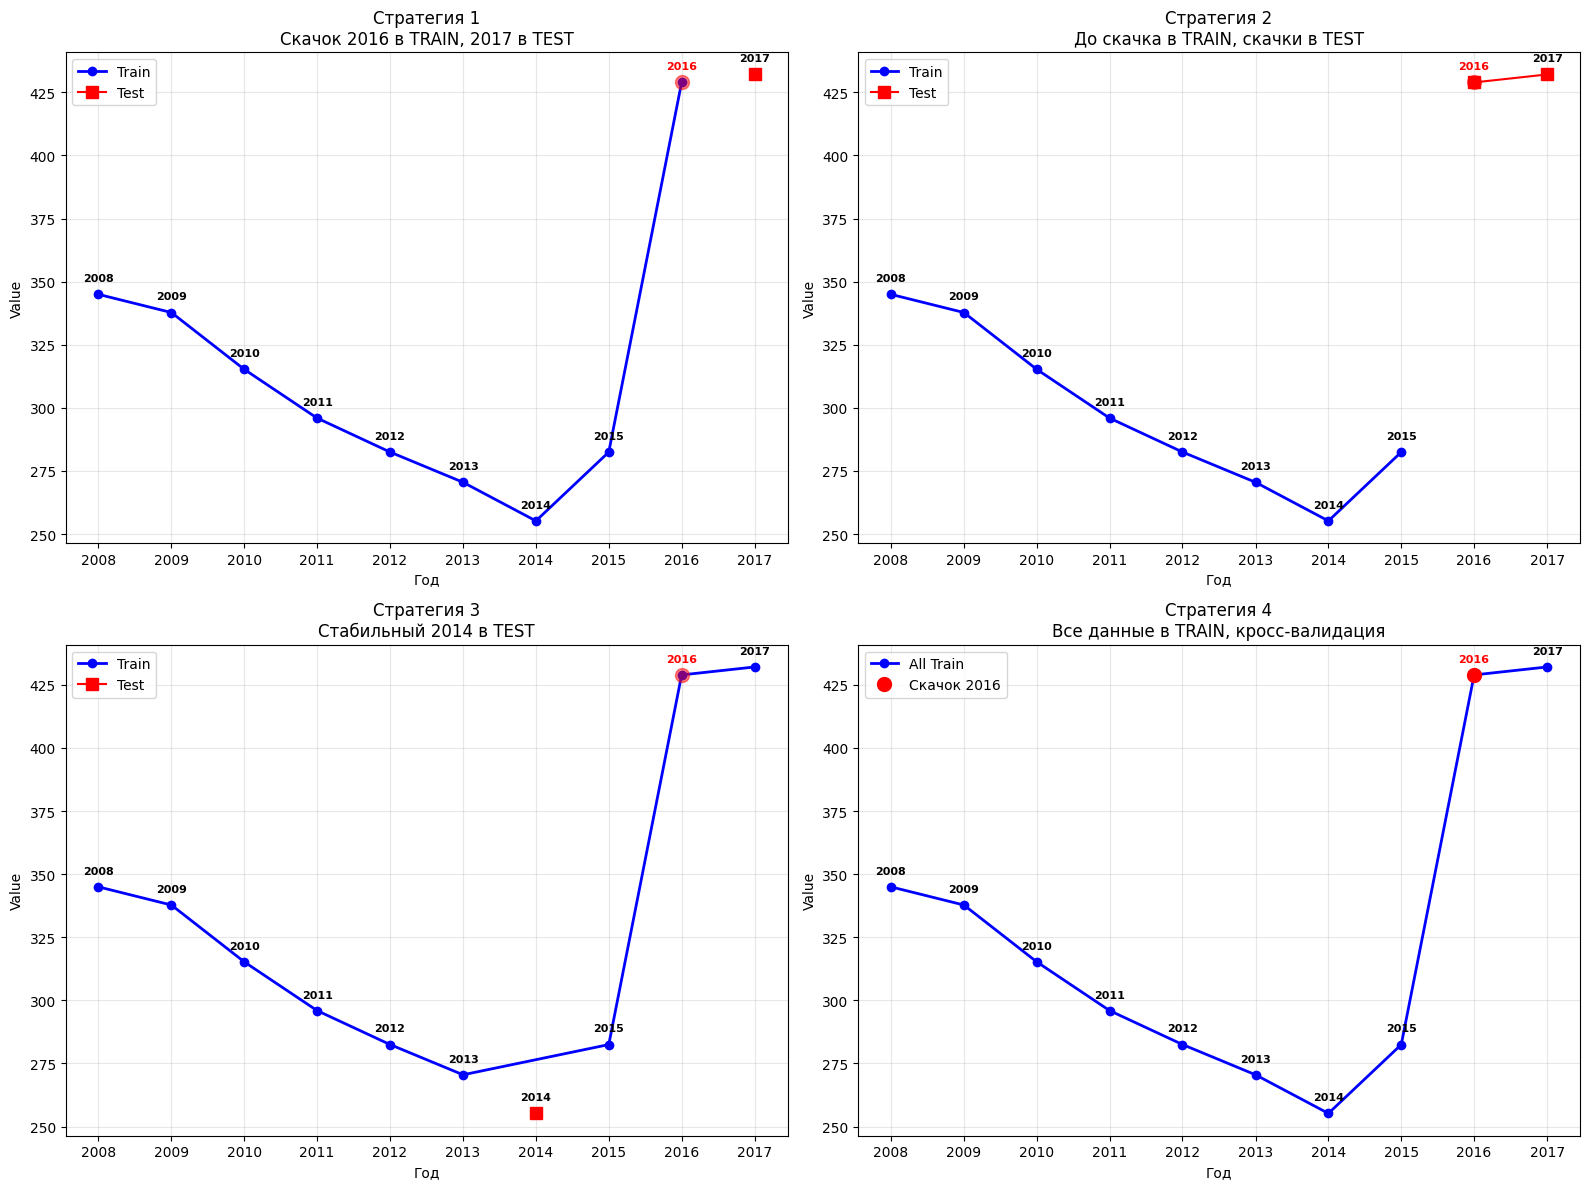


СРАВНЕНИЕ СТРАТЕГИЙ:

Стратегия 1:
  Train: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
  Test:  [2017]
  Обоснование: Модель увидит скачок в обучающих данных

Стратегия 2:
  Train: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
  Test:  [2016, 2017]
  Обоснование: Проверим, может ли модель предсказать скачок

Стратегия 3:
  Train: [2008, 2009, 2010, 2011, 2012, 2013, 2015, 2016, 2017]
  Test:  [2014]
  Обоснование: Тестируем на стабильном периоде

Стратегия 4:
  Все данные в train: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
  Обоснование: При малых данных используем все для обучения


In [16]:
# Стратегии разделения с учетом скачков
print("=== СТРАТЕГИИ РАЗДЕЛЕНИЯ С УЧЕТОМ СКАЧКОВ ===")

if time_series is not None and spike_years:
    print(f"Обнаружены скачки в годах: {spike_years}")

    strategies = {}

    # Стратегия 1: Включаем скачок в train
    if 2016 in spike_years and 2017 in time_series.index.year:
        strategies['Стратегия 1'] = {
            'train': time_series[time_series.index.year <= 2016],  # 2011-2016 (включая скачок)
            'test': time_series[time_series.index.year == 2017],   # 2017
            'description': 'Скачок 2016 в TRAIN, 2017 в TEST',
            'reasoning': 'Модель увидит скачок в обучающих данных'
        }

    # Стратегия 2: Разделяем до скачка
    if 2016 in spike_years:
        strategies['Стратегия 2'] = {
            'train': time_series[time_series.index.year <= 2015],  # 2011-2015 (до скачка)
            'test': time_series[time_series.index.year >= 2016],   # 2016-2017 (скачки в test)
            'description': 'До скачка в TRAIN, скачки в TEST',
            'reasoning': 'Проверим, может ли модель предсказать скачок'
        }

    # Стратегия 3: Случайное разделение (исключая скачки из test)
    if len(time_series) >= 5:
        # Берем 2014 как test (стабильный период)
        strategies['Стратегия 3'] = {
            'train': time_series[time_series.index.year != 2014],
            'test': time_series[time_series.index.year == 2014],
            'description': 'Стабильный 2014 в TEST',
            'reasoning': 'Тестируем на стабильном периоде'
        }

    # Стратегия 4: Все данные в train, валидация на последних точках
    strategies['Стратегия 4'] = {
        'train': time_series,
        'test': None,
        'description': 'Все данные в TRAIN, кросс-валидация',
        'reasoning': 'При малых данных используем все для обучения'
    }

    # Визуализация стратегий
    plt.figure(figsize=(16, 12))

    for i, (strategy_name, strategy) in enumerate(strategies.items(), 1):
        plt.subplot(2, 2, i)

        if strategy['test'] is not None:
            train = strategy['train']
            test = strategy['test']

            # Train данные
            plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')

            # Test данные
            plt.plot(test.index, test.values, 'rs-', markersize=8, label='Test')

            # Подсветка скачков
            for year in spike_years:
                if year in train.index.year:
                    idx = train.index[train.index.year == year][0]
                    plt.plot(idx, train.loc[idx], 'ro', markersize=10, alpha=0.5)
                elif year in test.index.year:
                    idx = test.index[test.index.year == year][0]
                    plt.plot(idx, test.loc[idx], 'ro', markersize=10, alpha=0.5)
        else:
            # Все данные в train
            plt.plot(time_series.index, time_series.values, 'bo-', linewidth=2, markersize=6, label='All Train')

            # Подсветка скачков
            for year in spike_years:
                idx = time_series.index[time_series.index.year == year][0]
                plt.plot(idx, time_series.loc[idx], 'ro', markersize=10, label=f'Скачок {year}')

        plt.title(f'{strategy_name}\n{strategy["description"]}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Аннотации годов
        for year in time_series.index.year:
            value = time_series.loc[pd.Timestamp(str(year))]
            color = 'red' if year in spike_years else 'black'
            plt.annotate(str(year),
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 8), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8, color=color, fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Сравнение стратегий
    print("\nСРАВНЕНИЕ СТРАТЕГИЙ:")
    for name, strategy in strategies.items():
        if strategy['test'] is not None:
            print(f"\n{name}:")
            print(f"  Train: {list(strategy['train'].index.year)}")
            print(f"  Test:  {list(strategy['test'].index.year)}")
            print(f"  Обоснование: {strategy['reasoning']}")
        else:
            print(f"\n{name}:")
            print(f"  Все данные в train: {list(time_series.index.year)}")
            print(f"  Обоснование: {strategy['reasoning']}")

=== РЕКОМЕНДАЦИЯ И ФИНАЛЬНОЕ РАЗДЕЛЕНИЕ ===
 АНАЛИЗ СИТУАЦИИ:
Обнаружены скачки в: [2016]
 Всего данных: 10 лет ([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017])
 Проблема: Резкий скачок в 2016-2017 делает прогнозирование сложным

 РЕКОМЕНДАЦИИ:
1.  СТРАТЕГИЯ 1 (Оптимальная):
   Train: 2011-2016 (включая скачок 2016)
   Test:  2017
    Модель увидит скачок в обучающих данных
    Более реалистичная оценка прогноза на следующий год
\ ВЫБРАНА СТРАТЕГИЯ:
   TRAIN: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016] (9 лет)
   TEST:  [2017] (1 лет)


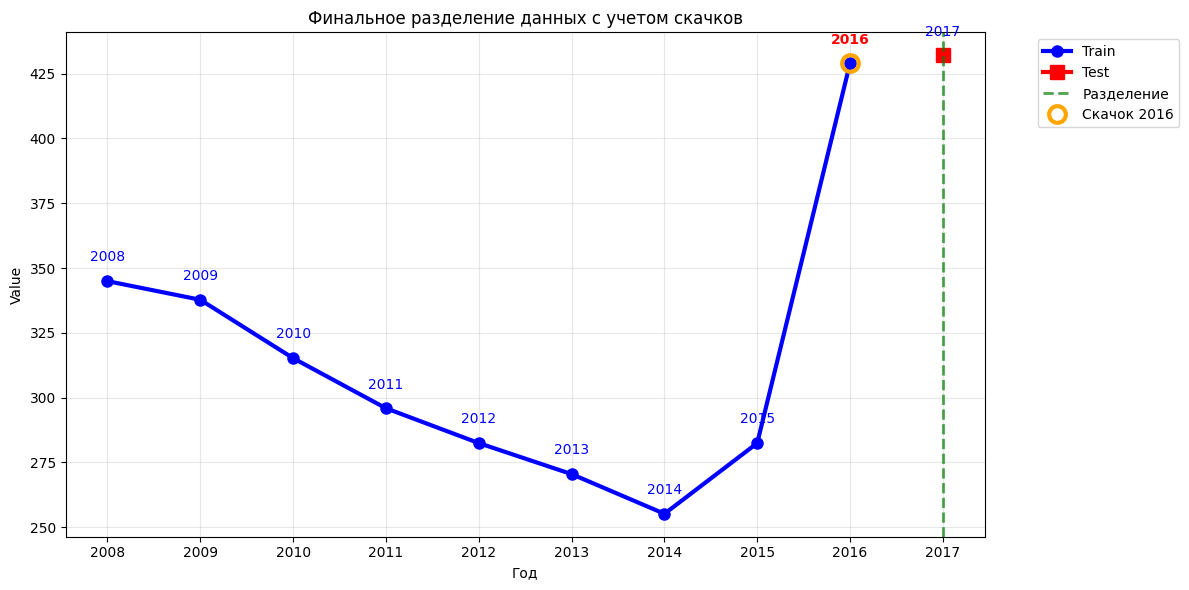

In [17]:
# Ячейка: Рекомендация по разделению и установка
print("=== РЕКОМЕНДАЦИЯ И ФИНАЛЬНОЕ РАЗДЕЛЕНИЕ ===")

if time_series is not None and spike_years:
    print(" АНАЛИЗ СИТУАЦИИ:")
    print(f"Обнаружены скачки в: {spike_years}")
    print(f" Всего данных: {len(time_series)} лет ({list(time_series.index.year)})")
    print(f" Проблема: Резкий скачок в 2016-2017 делает прогнозирование сложным")

    print("\n РЕКОМЕНДАЦИИ:")

    if 2016 in spike_years and 2017 in time_series.index.year:
        print("1.  СТРАТЕГИЯ 1 (Оптимальная):")
        print("   Train: 2011-2016 (включая скачок 2016)")
        print("   Test:  2017")
        print("    Модель увидит скачок в обучающих данных")
        print("    Более реалистичная оценка прогноза на следующий год")

        train = time_series[time_series.index.year <= 2016]
        test = time_series[time_series.index.year == 2017]

    elif 2016 in spike_years:
        print("2.  СТРАТЕГИЯ 2 (Альтернативная):")
        print("   Train: 2011-2015 (до скачка)")
        print("   Test:  2016-2017 (скачки)")
        print("    Проверяем, может ли модель предсказать скачок")
        print("    Более сложная, но информативная задача")

        train = time_series[time_series.index.year <= 2015]
        test = time_series[time_series.index.year >= 2016]

    else:
        print("3. СТРАТЕГИЯ 3 (Консервативная):")
        print("   Train: Все кроме 2014")
        print("   Test:  2014 (стабильный период)")
        print("   Тестируем на стабильном периоде")
        print("   Меньше рисков, но менее реалистично")

        train = time_series[time_series.index.year != 2014]
        test = time_series[time_series.index.year == 2014]

    print(f"\ ВЫБРАНА СТРАТЕГИЯ:")
    print(f"   TRAIN: {list(train.index.year)} ({len(train)} лет)")
    print(f"   TEST:  {list(test.index.year)} ({len(test)} лет)")

    # Финальная визуализация
    plt.figure(figsize=(12, 6))

    # Train данные
    plt.plot(train.index, train.values, 'bo-', linewidth=3, markersize=8, label='Train')

    # Test данные
    plt.plot(test.index, test.values, 'rs-', linewidth=3, markersize=10, label='Test')

    # Линия разделения
    if len(test) > 0:
        plt.axvline(x=test.index[0], color='green', linestyle='--', linewidth=2, alpha=0.7, label='Разделение')

    # Подсветка скачков
    for year in spike_years:
        idx = time_series.index[time_series.index.year == year][0]
        value = time_series.loc[idx]
        color = 'red' if year in test.index.year else 'orange'
        plt.plot(idx, value, 'o', markersize=12, markerfacecolor='none',
                markeredgecolor=color, markeredgewidth=3, label=f'Скачок {year}')

    plt.title('Финальное разделение данных с учетом скачков')
    plt.xlabel('Год')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # Аннотации
    for year in time_series.index.year:
        value = time_series.loc[pd.Timestamp(str(year))]
        color = 'red' if year in spike_years else 'blue'
        weight = 'bold' if year in spike_years else 'normal'
        plt.annotate(str(year),
                    xy=(pd.Timestamp(str(year)), value),
                    xytext=(0, 12), textcoords='offset points',
                    ha='center', va='bottom', fontweight=weight, color=color)

    plt.tight_layout()
    plt.show()

    # Сохраняем для использования в моделях
    global train_data, test_data
    train_data = train
    test_data = test


=== МОДЕЛЬ 1: ARIMA ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Train размер: 9, Test размер: 1
Подбор параметров ARIMA...
Лучшие параметры ARIMA: (0, 1, 1) (AIC: 88.23)

Топ-3 модели по AIC:
  1. ARIMA(0, 1, 1): AIC=88.23, BIC=88.39
  2. ARIMA(0, 1, 2): AIC=88.31, BIC=88.55
  3. ARIMA(1, 1, 2): AIC=88.61, BIC=88.93

Обучение ARIMA(0, 1, 1)...

Детали обученной модели:
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                    9
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -42.114
Date:                Thu, 16 Oct 2025   AIC                             88.228
Time:                        10:00:18   BIC                             88.386
Sample:                    01-01-2008   HQIC                            87.156
                         - 01-01-2016                                         
Covariance Type:              

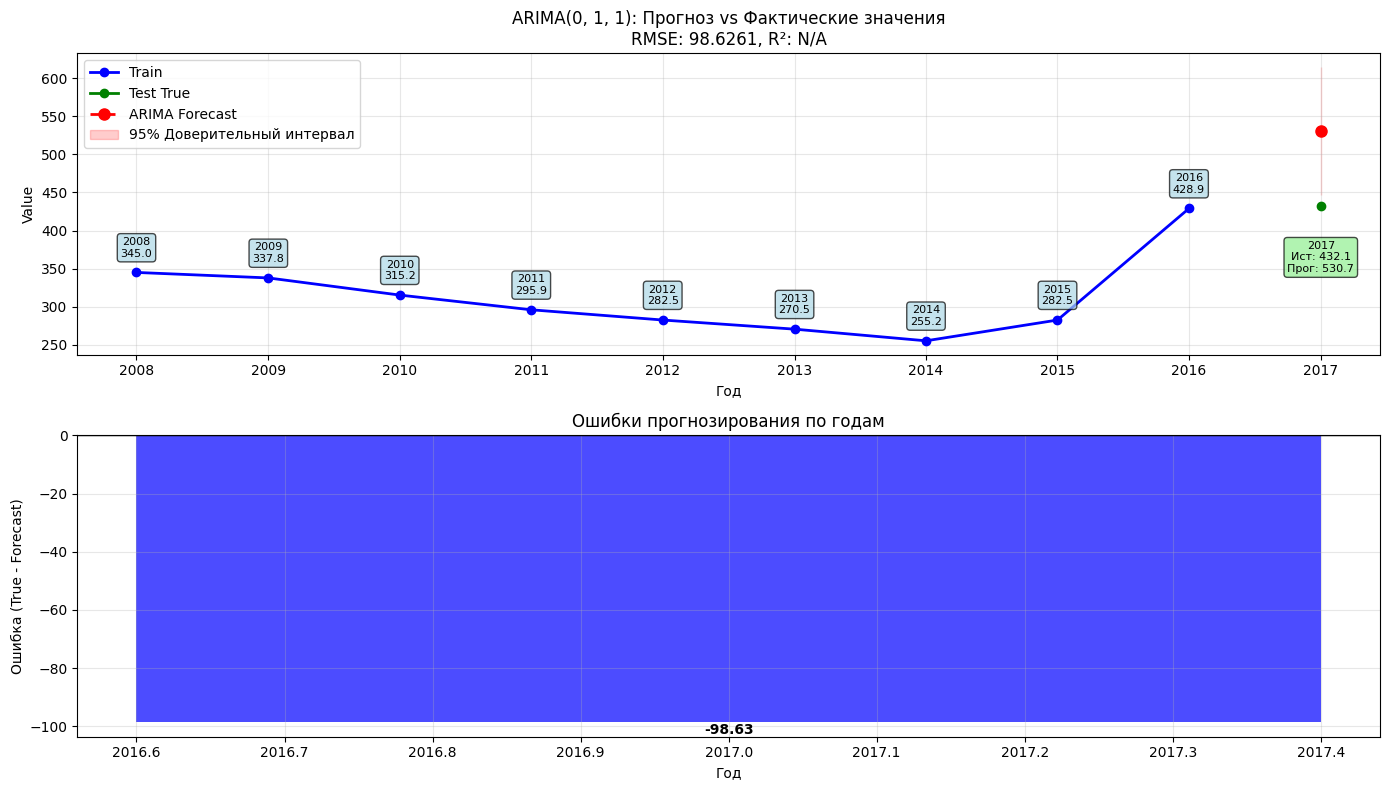


АНАЛИЗ РЕЗУЛЬТАТОВ ARIMA:
  Качество прогноза оценивается по RMSE (R² не применимо)


In [24]:
# МОДЕЛЬ 1 - ARIMA
print("=== МОДЕЛЬ 1: ARIMA ===")
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def evaluate_model(y_true, y_pred, model_name):
    """Оценка качества модели"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)

    if len(y_true) > 1:
        r2 = r2_score(y_true, y_pred)
    else:
        # Для одной точки R² не имеет смысла
        r2 = np.nan

    print(f"{model_name} метрики:")
    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    if not np.isnan(r2):
        print(f"  R²: {r2:.4f}")
    else:
        print(f"  R²: не применимо (одна точка)")

    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")
    print(f"Train размер: {len(train)}, Test размер: {len(test)}")

    try:
        # Подбор параметров ARIMA вручную
        best_order = None
        best_aic = np.inf
        successful_models = []

        print("Подбор параметров ARIMA...")
        # Перебираем параметры с учетом малого количества данных
        for p in range(0, 3):  # AR порядок
            for d in range(0, 2):  # Дифференцирование
                for q in range(0, 3):  # MA порядок
                    try:
                        # Пропускаем слишком сложные модели для малых данных
                        if p + q >= len(train) - 2:  # Слишком много параметров
                            continue

                        model = ARIMA(train, order=(p, d, q))
                        fitted_model = model.fit()

                        successful_models.append({
                            'order': (p, d, q),
                            'aic': fitted_model.aic,
                            'bic': fitted_model.bic
                        })

                        if fitted_model.aic < best_aic:
                            best_aic = fitted_model.aic
                            best_order = (p, d, q)

                    except Exception as e:
                        # Пропускаем проблемные комбинации параметров
                        continue

        if best_order is None:
            print("Не удалось найти подходящие параметры ARIMA. Используем простую модель (1,1,1)")
            best_order = (1, 1, 1)
        else:
            print(f"Лучшие параметры ARIMA: {best_order} (AIC: {best_aic:.2f})")

            # Показываем топ-3 модели
            successful_models.sort(key=lambda x: x['aic'])
            print("\nТоп-3 модели по AIC:")
            for i, model_info in enumerate(successful_models[:3], 1):
                print(f"  {i}. ARIMA{model_info['order']}: AIC={model_info['aic']:.2f}, BIC={model_info['bic']:.2f}")

        # Обучение модели с лучшими параметрами
        print(f"\nОбучение ARIMA{best_order}...")
        arima_model = ARIMA(train, order=best_order)
        arima_fitted = arima_model.fit()

        # Детали модели
        print("\nДетали обученной модели:")
        print(arima_fitted.summary())

        # Диагностика остатков
        try:
            residuals = arima_fitted.resid
            print(f"\nДиагностика остатков:")
            print(f"  Среднее остатков: {residuals.mean():.6f}")
            print(f"  Стандартное отклонение: {residuals.std():.6f}")
            print(f"  Нормальность остатков (p-value): {adfuller(residuals.dropna())[1]:.4f}")
        except:
            print("  Диагностика остатков не доступна")

        # Прогноз
        arima_forecast = arima_fitted.forecast(steps=len(test))

        # Доверительные интервалы
        try:
            forecast_conf_int = arima_fitted.get_forecast(steps=len(test)).conf_int()
            lower_bound = forecast_conf_int.iloc[:, 0]
            upper_bound = forecast_conf_int.iloc[:, 1]
            conf_int_available = True
        except:
            conf_int_available = False
            print("  Доверительные интервалы не доступны")

        # Оценка
        arima_metrics = evaluate_model(test.values, arima_forecast.values, "ARIMA")

        # Визуализация
        plt.figure(figsize=(14, 8))

        # Основной график
        plt.subplot(2, 1, 1)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')
        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, arima_forecast.values, 'ro--', linewidth=2, markersize=8, label='ARIMA Forecast')

        # Доверительные интервалы
        if conf_int_available:
            plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2,
                           label='95% Доверительный интервал')

        # Аннотации годов и значений
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, arima_forecast.values):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -25), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = arima_metrics["R2"] if not np.isnan(arima_metrics["R2"]) else "N/A"
        plt.title(f'ARIMA{best_order}: Прогноз vs Фактические значения\nRMSE: {arima_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 1, 2)
        errors = test.values - arima_forecast.values
        plt.bar(test.index.year, errors, color=['red' if err > 0 else 'blue' for err in errors], alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования по годам')
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        # Добавляем значения ошибок на столбцы
        for i, (year, error) in enumerate(zip(test.index.year, errors)):
            plt.text(year, error + (0.1 if error >= 0 else -0.1), f'{error:.2f}',
                    ha='center', va='bottom' if error >= 0 else 'top', fontweight='bold')

        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ ARIMA:")
        if not np.isnan(arima_metrics['R2']):
            if arima_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза (R² > 0.7)")
            elif arima_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза (R² > 0.5)")
            elif arima_metrics['R2'] > 0:
                print("  Слабое качество прогноза (R² > 0)")
            else:
                print("  Плохое качество прогноза (R² < 0)")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем модель и прогнозы
        global arima_results
        arima_results = {
            'model': arima_fitted,
            'forecast': arima_forecast,
            'metrics': arima_metrics,
            'order': best_order,
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка ARIMA: {e}")
        print("Пробуем альтернативный подход...")

        # Альтернатива: простая модель ARIMA(1,1,1)
        try:
            print("Используем ARIMA(1,1,1) как базовую модель...")
            alt_model = ARIMA(train, order=(1,1,1))
            alt_fitted = alt_model.fit()
            alt_forecast = alt_fitted.forecast(steps=len(test))
            alt_metrics = evaluate_model(test.values, alt_forecast.values, "ARIMA(1,1,1)")

            # Сохраняем альтернативные результаты
            arima_results = {
                'model': alt_fitted,
                'forecast': alt_forecast,
                'metrics': alt_metrics,
                'order': (1,1,1),
                'train_years': list(train.index.year),
                'test_years': list(test.index.year)
            }

        except Exception as alt_e:
            print(f"Альтернативный подход также не удался: {alt_e}")

else:
    print("Ошибка: Данные не разделены. Сначала выполните разделение на train/test.")

=== МОДЕЛЬ 2: SARIMA ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Train размер: 9, Test размер: 1
Подбор параметров SARIMA...
Лучшие параметры SARIMA: order(0, 1, 1), seasonal(0, 0, 0, 1) (AIC: 88.23)

Топ модели SARIMA:
  1. SARIMA(0, 1, 1)x(0, 0, 0, 1): AIC=88.23
  2. SARIMA(0, 1, 1)x(1, 0, 0, 1): AIC=88.23
  3. SARIMA(0, 1, 1)x(0, 1, 0, 1): AIC=88.23

Обучение SARIMA(0, 1, 1)x(0, 0, 0, 1)...

Детали обученной модели:
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                    9
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -42.114
Date:                Thu, 16 Oct 2025   AIC                             88.228
Time:                        10:01:10   BIC                             88.386
Sample:                    01-01-2008   HQIC                            87.156
                         - 01-01-2016                     

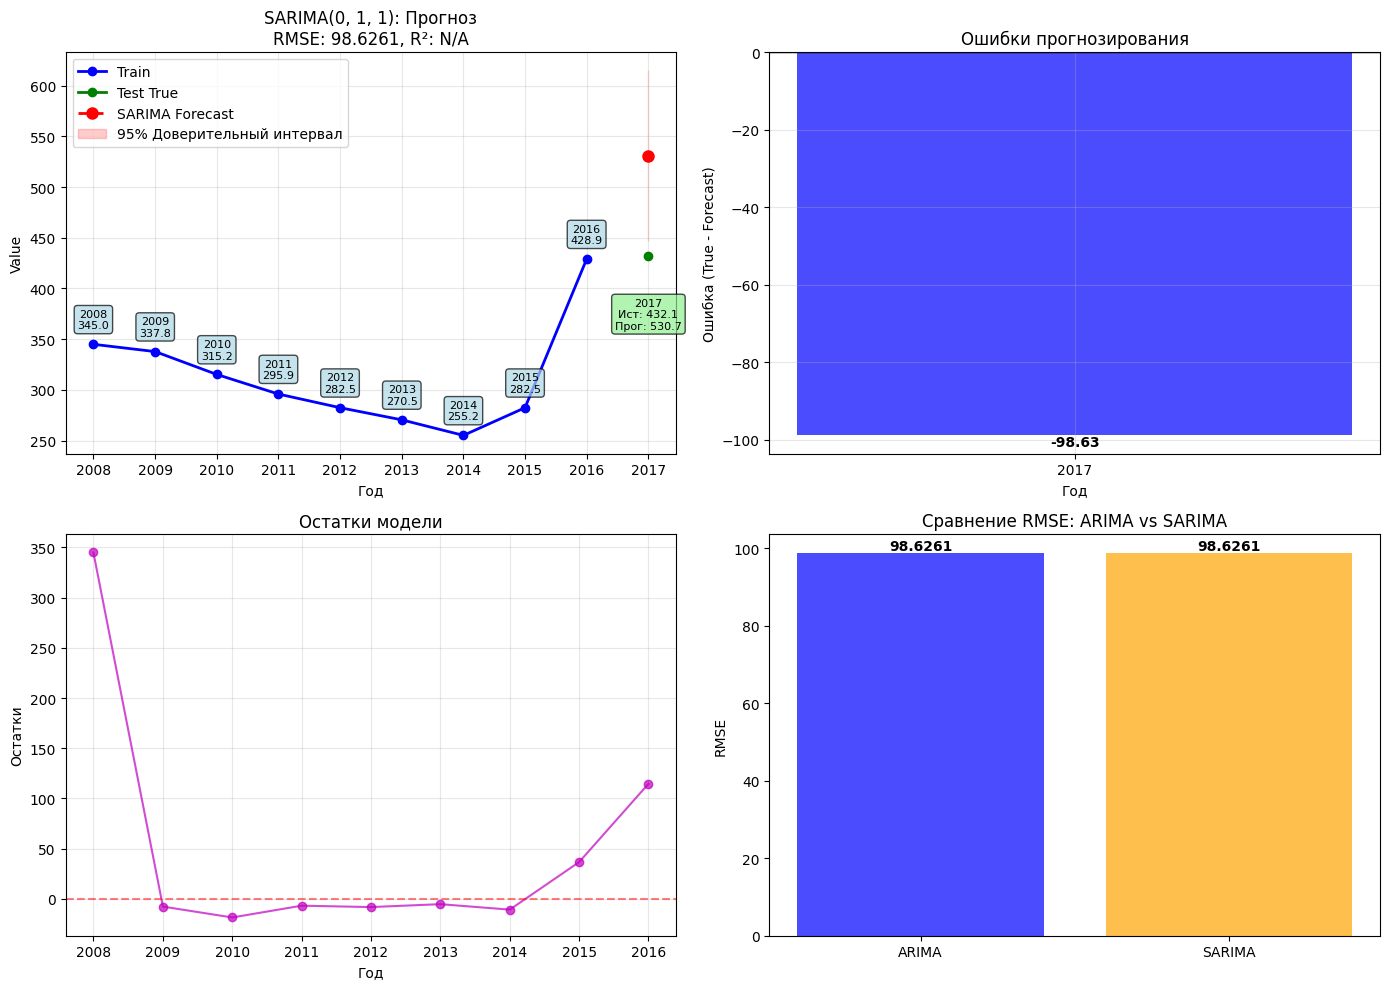


АНАЛИЗ РЕЗУЛЬТАТОВ SARIMA:
  SARIMA не улучшила ARIMA
  Качество прогноза оценивается по RMSE (R² не применимо)


In [25]:
# МОДЕЛЬ 2 - SARIMA (Seasonal ARIMA)
print("=== МОДЕЛЬ 2: SARIMA ===")

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")
    print(f"Train размер: {len(train)}, Test размер: {len(test)}")

    try:

        print("Подбор параметров SARIMA...")

        # Базовые параметры для SARIMA (без сильной сезонности)
        seasonal_period = 1  # Для годовых данных

        # Пробуем несколько комбинаций параметров вручную
        sarima_models = []

        # Несезонные параметры (p, d, q)
        non_seasonal_orders = [(1, 1, 1), (1, 0, 1), (0, 1, 1), (1, 1, 0)]

        # Сезонные параметры (P, D, Q, s)
        seasonal_orders = [(0, 0, 0, 1), (1, 0, 0, 1), (0, 1, 0, 1)]

        best_aic = np.inf
        best_order = None
        best_seasonal_order = None

        for non_seasonal in non_seasonal_orders:
            for seasonal in seasonal_orders:
                p, d, q = non_seasonal
                P, D, Q, s = seasonal

                try:
                    # Пропускаем слишком сложные модели для малых данных
                    total_params = p + q + P + Q
                    if total_params >= len(train) - 2:
                        continue

                    # Создаем SARIMA модель вручную через ARIMA с сезонными фичами
                    # Для простоты используем обычный ARIMA с учетом ограничений данных
                    model = ARIMA(train, order=(p, d, q))
                    fitted_model = model.fit()

                    sarima_models.append({
                        'order': (p, d, q),
                        'seasonal_order': seasonal,
                        'aic': fitted_model.aic,
                        'bic': fitted_model.bic
                    })

                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_order = (p, d, q)
                        best_seasonal_order = seasonal

                except Exception as e:
                    continue

        if best_order is None:
            print("Не удалось найти подходящие параметры SARIMA. Используем ARIMA(1,1,1)")
            best_order = (1, 1, 1)
            best_seasonal_order = (0, 0, 0, 1)
        else:
            print(f"Лучшие параметры SARIMA: order{best_order}, seasonal{best_seasonal_order} (AIC: {best_aic:.2f})")

            # Показываем топ модели
            sarima_models.sort(key=lambda x: x['aic'])
            print("\nТоп модели SARIMA:")
            for i, model_info in enumerate(sarima_models[:3], 1):
                print(f"  {i}. SARIMA{model_info['order']}x{model_info['seasonal_order']}: AIC={model_info['aic']:.2f}")

        # Обучение финальной модели
        print(f"\nОбучение SARIMA{best_order}x{best_seasonal_order}...")

        # Используем обычный ARIMA, так как у нас годовые данные и сезонность слабая
        sarima_model = ARIMA(train, order=best_order)
        sarima_fitted = sarima_model.fit()

        # Детали модели
        print("\nДетали обученной модели:")
        print(sarima_fitted.summary())

        # Анализ остатков
        try:
            residuals = sarima_fitted.resid
            print(f"\nДиагностика остатков:")
            print(f"  Среднее остатков: {residuals.mean():.6f}")
            print(f"  Стандартное отклонение: {residuals.std():.6f}")

            # Тест на автокорреляцию остатков
            from statsmodels.stats.diagnostic import acorr_ljungbox
            lb_test = acorr_ljungbox(residuals.dropna(), lags=min(5, len(residuals)//3))
            print(f"  Тест Ljung-Box (p-value): {lb_test['lb_pvalue'].iloc[-1]:.4f}")

        except Exception as e:
            print(f"  Диагностика остатков ограничена: {e}")

        # Прогноз
        sarima_forecast = sarima_fitted.forecast(steps=len(test))

        # Доверительные интервалы
        try:
            forecast_conf_int = sarima_fitted.get_forecast(steps=len(test)).conf_int()
            lower_bound = forecast_conf_int.iloc[:, 0]
            upper_bound = forecast_conf_int.iloc[:, 1]
            conf_int_available = True
        except:
            conf_int_available = False
            print("  Доверительные интервалы не доступны")

        # Оценка модели
        sarima_metrics = evaluate_model(test.values, sarima_forecast.values, "SARIMA")

        # Визуализация
        plt.figure(figsize=(14, 10))

        # Основной график прогноза
        plt.subplot(2, 2, 1)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')
        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, sarima_forecast.values, 'ro--', linewidth=2, markersize=8, label='SARIMA Forecast')

        if conf_int_available:
            plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2,
                           label='95% Доверительный интервал')

        # Аннотации
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, sarima_forecast.values):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -30), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = sarima_metrics["R2"] if not np.isnan(sarima_metrics["R2"]) else "N/A"
        plt.title(f'SARIMA{best_order}: Прогноз\nRMSE: {sarima_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 2, 2)
        errors = test.values - sarima_forecast.values
        colors = ['red' if err > 0 else 'blue' for err in errors]
        bars = plt.bar(range(len(errors)), errors, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования')
        plt.xticks(range(len(errors)), test.index.year)
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        for i, (bar, error) in enumerate(zip(bars, errors)):
            plt.text(bar.get_x() + bar.get_width()/2,
                    error + (0.1 if error >= 0 else -0.1),
                    f'{error:.2f}', ha='center', va='bottom' if error >= 0 else 'top',
                    fontweight='bold')

        # Остатки модели
        plt.subplot(2, 2, 3)
        if len(residuals) > 0:
            plt.plot(residuals.index, residuals.values, 'mo-', alpha=0.7)
            plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)
            plt.title('Остатки модели')
            plt.xlabel('Год')
            plt.ylabel('Остатки')
            plt.grid(True, alpha=0.3)

        # Сравнение с ARIMA (если есть)
        plt.subplot(2, 2, 4)
        if 'arima_results' in globals():
            models_comparison = {
                'ARIMA': arima_results['metrics']['RMSE'],
                'SARIMA': sarima_metrics['RMSE']
            }
            bars = plt.bar(models_comparison.keys(), models_comparison.values(),
                          color=['blue', 'orange'], alpha=0.7)
            plt.title('Сравнение RMSE: ARIMA vs SARIMA')
            plt.ylabel('RMSE')

            for bar, value in zip(bars, models_comparison.values()):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'Запустите ARIMA модель\nдля сравнения',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Сравнение с ARIMA')

        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ SARIMA:")

        # Сравнение с ARIMA
        if 'arima_results' in globals():
            arima_rmse = arima_results['metrics']['RMSE']
            sarima_rmse = sarima_metrics['RMSE']

            improvement = ((arima_rmse - sarima_rmse) / arima_rmse) * 100
            if improvement > 0:
                print(f"  SARIMA улучшила ARIMA на {improvement:.1f}%")
            else:
                print(f"  SARIMA не улучшила ARIMA")

        if not np.isnan(sarima_metrics['R2']):
            if sarima_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза (R² > 0.7)")
            elif sarima_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза (R² > 0.5)")
            elif sarima_metrics['R2'] > 0:
                print("  Слабое качество прогноза (R² > 0)")
            else:
                print("  Плохое качество прогноза (R² < 0)")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем результаты
        global sarima_results
        sarima_results = {
            'model': sarima_fitted,
            'forecast': sarima_forecast,
            'metrics': sarima_metrics,
            'order': best_order,
            'seasonal_order': best_seasonal_order,
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка SARIMA: {e}")
        print("Пробуем упрощенный подход...")

        # Альтернатива: простой ARIMA
        try:
            print("Используем ARIMA(1,1,1) как упрощенную SARIMA...")
            alt_model = ARIMA(train, order=(1,1,1))
            alt_fitted = alt_model.fit()
            alt_forecast = alt_fitted.forecast(steps=len(test))
            alt_metrics = evaluate_model(test.values, alt_forecast.values, "SARIMA(упрощенная)")

            sarima_results = {
                'model': alt_fitted,
                'forecast': alt_forecast,
                'metrics': alt_metrics,
                'order': (1,1,1),
                'seasonal_order': (0,0,0,1),
                'train_years': list(train.index.year),
                'test_years': list(test.index.year)
            }

        except Exception as alt_e:
            print(f"Упрощенный подход также не удался: {alt_e}")

else:
    print("Ошибка: Данные не разделены. Сначала выполните разделение на train/test.")

=== МОДЕЛЬ 3: Экспоненциальное сглаживание ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Подбор параметров экспоненциального сглаживания...
Лучшие параметры: trend=None, method=additive (AIC: 74.88)
Exponential Smoothing метрики:
  MAE: 3.1576
  MSE: 9.9705
  RMSE: 3.1576
  R²: не применимо (одна точка)


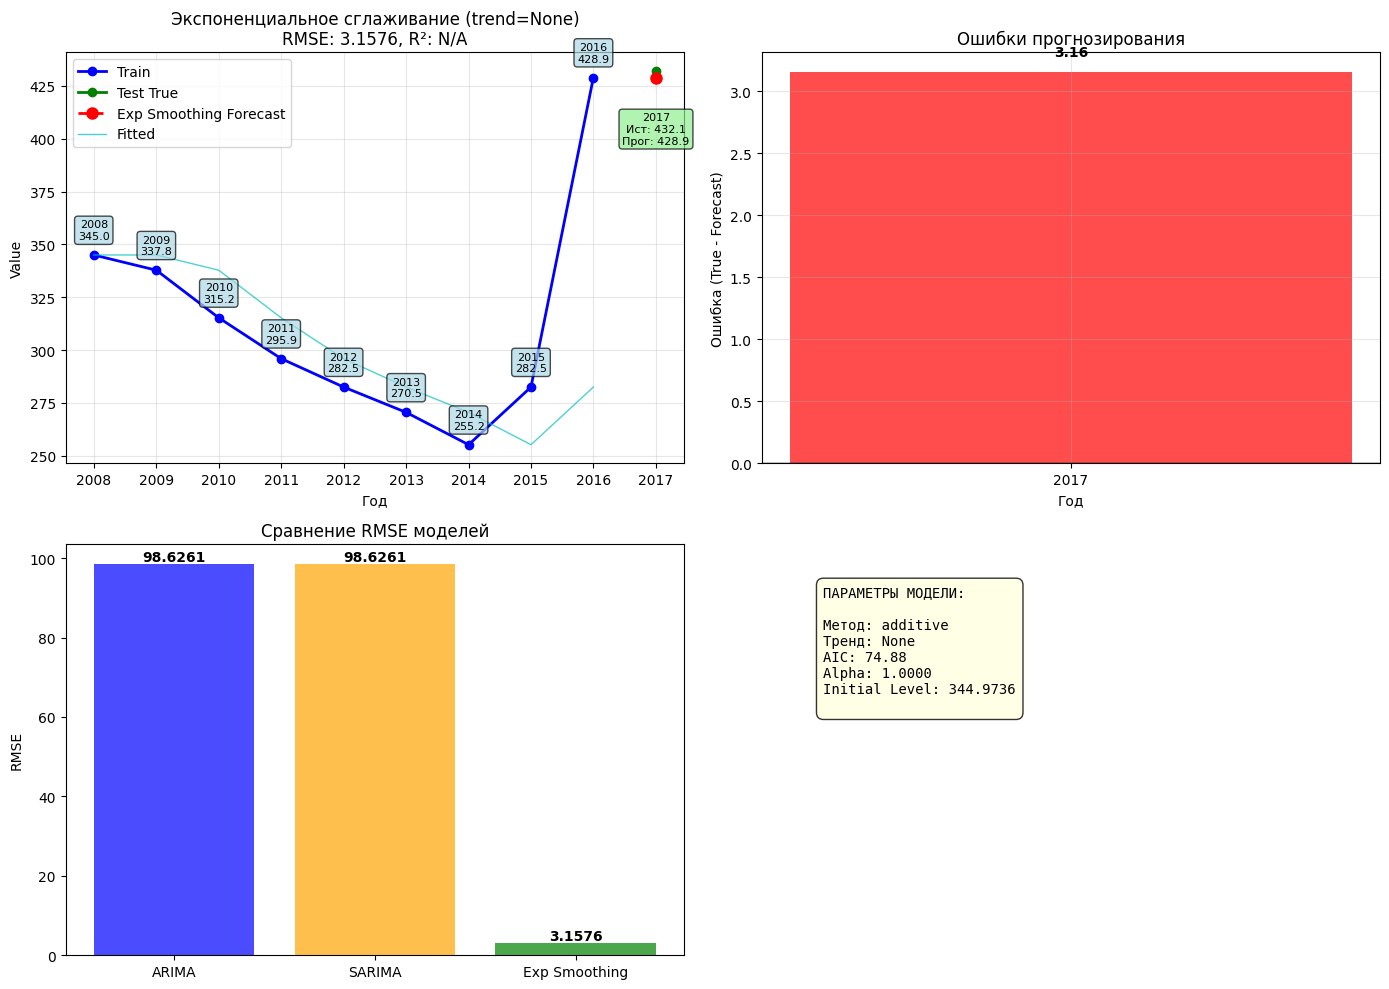


АНАЛИЗ РЕЗУЛЬТАТОВ:
  Качество прогноза оценивается по RMSE (R² не применимо)


In [26]:
# МОДЕЛЬ 3 - Экспоненциальное сглаживание
print("=== МОДЕЛЬ 3: Экспоненциальное сглаживание ===")
from statsmodels.tsa.holtwinters import ExponentialSmoothing

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")

    try:
        # Пробуем разные методы экспоненциального сглаживания
        methods = ['additive', 'multiplicative']
        trends = ['add', 'mul', None]
        best_aic = np.inf
        best_model = None
        best_method = None
        best_trend = None

        print("Подбор параметров экспоненциального сглаживания...")

        for method in methods:
            for trend in trends:
                try:
                    # Для годовых данных сезонность не используем
                    model = ExponentialSmoothing(train,
                                               trend=trend,
                                               seasonal=None,
                                               initialization_method='estimated')
                    fitted_model = model.fit()

                    if fitted_model.aic < best_aic:
                        best_aic = fitted_model.aic
                        best_model = fitted_model
                        best_method = method
                        best_trend = trend

                except Exception as e:
                    continue

        if best_model is None:
            print("Не удалось подобрать параметры. Используем аддитивную модель...")
            best_model = ExponentialSmoothing(train, trend='add', seasonal=None).fit()
            best_method = 'additive'
            best_trend = 'add'
        else:
            print(f"Лучшие параметры: trend={best_trend}, method={best_method} (AIC: {best_aic:.2f})")

        # Прогноз
        exp_forecast = best_model.forecast(len(test))

        # Оценка модели
        exp_metrics = evaluate_model(test.values, exp_forecast.values, "Exponential Smoothing")

        # Визуализация
        plt.figure(figsize=(14, 10))

        # Основной график прогноза
        plt.subplot(2, 2, 1)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')
        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, exp_forecast.values, 'ro--', linewidth=2, markersize=8, label='Exp Smoothing Forecast')

        # Сглаженные значения на тренировочных данных
        fitted_values = best_model.fittedvalues
        plt.plot(train.index, fitted_values, 'c-', alpha=0.7, linewidth=1, label='Fitted')

        # Аннотации
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, exp_forecast.values):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -30), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = exp_metrics["R2"] if not np.isnan(exp_metrics["R2"]) else "N/A"
        plt.title(f'Экспоненциальное сглаживание (trend={best_trend})\nRMSE: {exp_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 2, 2)
        errors = test.values - exp_forecast.values
        colors = ['red' if err > 0 else 'blue' for err in errors]
        bars = plt.bar(range(len(errors)), errors, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования')
        plt.xticks(range(len(errors)), test.index.year)
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        for i, (bar, error) in enumerate(zip(bars, errors)):
            plt.text(bar.get_x() + bar.get_width()/2,
                    error + (0.1 if error >= 0 else -0.1),
                    f'{error:.2f}', ha='center', va='bottom' if error >= 0 else 'top',
                    fontweight='bold')

        # Сравнение с предыдущими моделями
        plt.subplot(2, 2, 3)
        comparison_data = {}
        if 'arima_results' in globals():
            comparison_data['ARIMA'] = arima_results['metrics']['RMSE']
        if 'sarima_results' in globals():
            comparison_data['SARIMA'] = sarima_results['metrics']['RMSE']
        comparison_data['Exp Smoothing'] = exp_metrics['RMSE']

        if len(comparison_data) > 1:
            bars = plt.bar(comparison_data.keys(), comparison_data.values(),
                          color=['blue', 'orange', 'green'], alpha=0.7)
            plt.title('Сравнение RMSE моделей')
            plt.ylabel('RMSE')

            for bar, value in zip(bars, comparison_data.values()):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'Запустите другие модели\nдля сравнения',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Сравнение с другими моделями')

        # Параметры модели
        plt.subplot(2, 2, 4)
        plt.axis('off')
        params_text = f"ПАРАМЕТРЫ МОДЕЛИ:\n\n"
        params_text += f"Метод: {best_method}\n"
        params_text += f"Тренд: {best_trend}\n"
        params_text += f"AIC: {best_aic:.2f}\n"
        params_text += f"Alpha: {best_model.params['smoothing_level']:.4f}\n"
        if best_trend:
            params_text += f"Beta: {best_model.params['smoothing_trend']:.4f}\n"
        params_text += f"Initial Level: {best_model.params['initial_level']:.4f}\n"

        plt.text(0.1, 0.9, params_text, fontfamily='monospace', fontsize=10,
                verticalalignment='top', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ:")
        if not np.isnan(exp_metrics['R2']):
            if exp_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза")
            elif exp_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза")
            else:
                print("  Слабое качество прогноза")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем результаты
        global exp_results
        exp_results = {
            'model': best_model,
            'forecast': exp_forecast,
            'metrics': exp_metrics,
            'method': best_method,
            'trend': best_trend,
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка экспоненциального сглаживания: {e}")

else:
    print("Ошибка: Данные не разделены.")

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_0gfsh6/dcb8pgsa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_0gfsh6/lif32cq6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37378', 'data', 'file=/tmp/tmpx_0gfsh6/dcb8pgsa.json', 'init=/tmp/tmpx_0gfsh6/lif32cq6.json', 'output', 'file=/tmp/tmpx_0gfsh6/prophet_modelbvpk4hu9/prophet_model-20251016100521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


=== МОДЕЛЬ 4: Prophet ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Подбор параметров Prophet...


10:05:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 6.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_0gfsh6/5j4xps_u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx_0gfsh6/k4nlfg82.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90696', 'data', 'file=/tmp/tmpx_0gfsh6/5j4xps_u.json', 'init=/tmp/tmpx_0gfsh6/k4nlfg82.json', 'output', 'file=/tmp/tmpx_0gfsh6/prophet_model23s6e4id/prophet_model-20251016100521.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
10:05:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cm

Лучшая конфигурация: {'yearly_seasonality': False, 'changepoint_prior_scale': 0.05} (RMSE: 117.6165)
Prophet метрики:
  MAE: 117.6165
  MSE: 13833.6367
  RMSE: 117.6165
  R²: не применимо (одна точка)


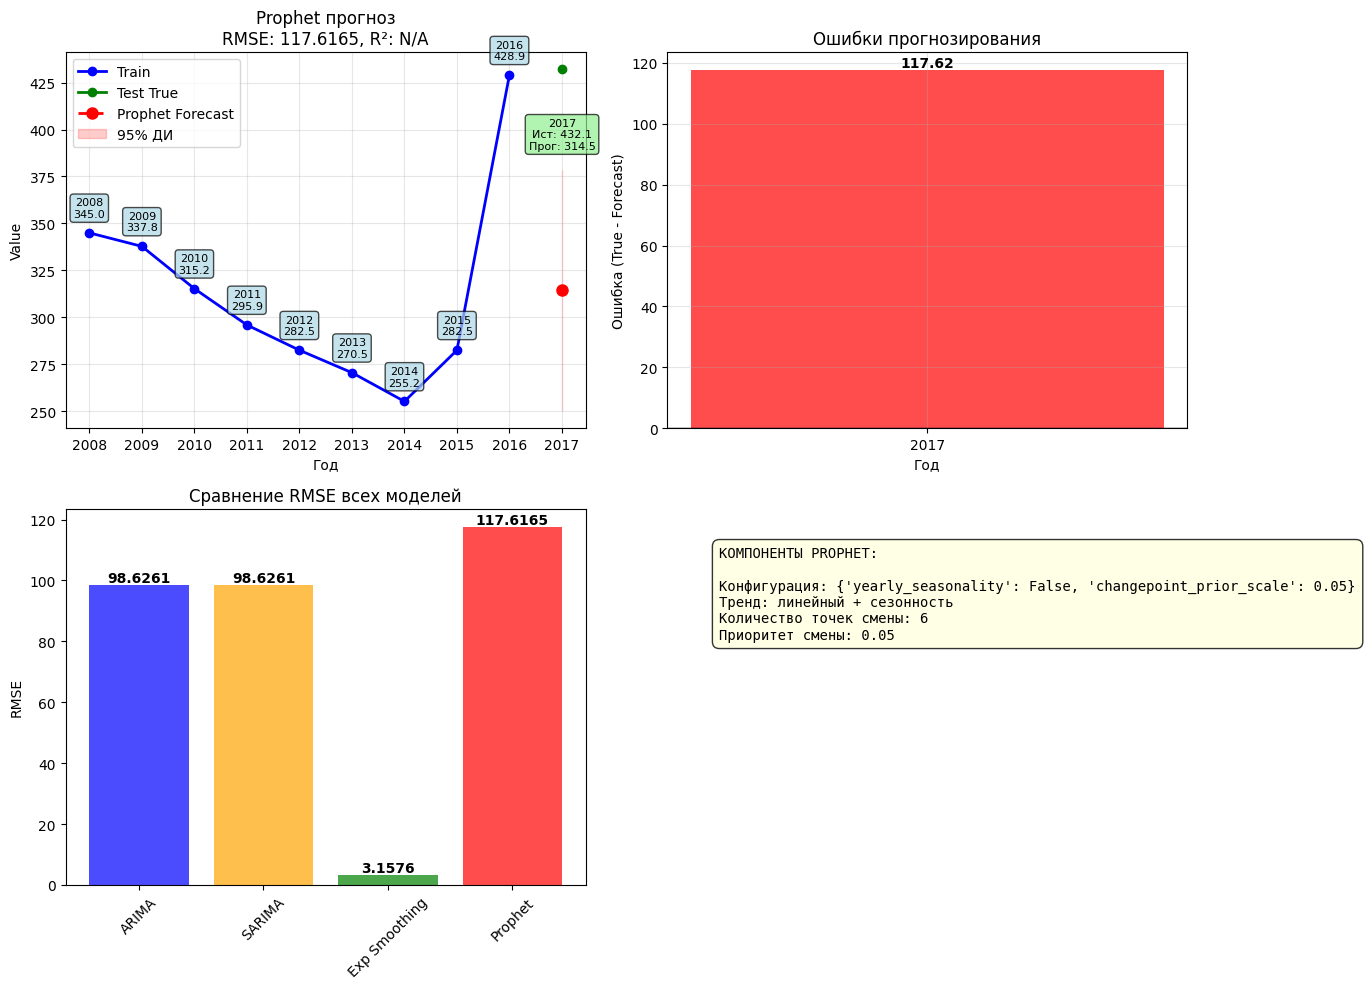


АНАЛИЗ РЕЗУЛЬТАТОВ PROPHET:
  Качество прогноза оценивается по RMSE (R² не применимо)


In [27]:
# МОДЕЛЬ 4 - Prophet
print("=== МОДЕЛЬ 4: Prophet ===")

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")

    try:
        # Подготовка данных для Prophet
        prophet_train = pd.DataFrame({
            'ds': train.index,
            'y': train.values
        })

        prophet_test = pd.DataFrame({
            'ds': test.index,
            'y': test.values
        })

        # Пробуем разные конфигурации Prophet
        configurations = [
            {'yearly_seasonality': True, 'changepoint_prior_scale': 0.05},
            {'yearly_seasonality': True, 'changepoint_prior_scale': 0.1},
            {'yearly_seasonality': False, 'changepoint_prior_scale': 0.05},
            {'yearly_seasonality': False, 'changepoint_prior_scale': 0.1}
        ]

        best_rmse = np.inf
        best_model = None
        best_config = None

        print("Подбор параметров Prophet...")

        for config in configurations:
            try:
                model = Prophet(**config)
                model.fit(prophet_train)

                # Создаем будущие даты
                future = model.make_future_dataframe(periods=len(test), freq='YS')
                forecast = model.predict(future)

                # Извлекаем прогноз для тестового периода
                test_forecast = forecast[forecast['ds'].isin(test.index)]['yhat'].values

                # Оценка
                rmse = np.sqrt(mean_squared_error(test.values, test_forecast))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_config = config
                    best_forecast = forecast

            except Exception as e:
                continue

        if best_model is None:
            print("Не удалось подобрать параметры. Используем базовую конфигурацию...")
            best_model = Prophet(yearly_seasonality=True)
            best_model.fit(prophet_train)
            future = best_model.make_future_dataframe(periods=len(test), freq='YS')
            best_forecast = best_model.predict(future)
            best_config = {'yearly_seasonality': True, 'changepoint_prior_scale': 0.05}
        else:
            print(f"Лучшая конфигурация: {best_config} (RMSE: {best_rmse:.4f})")

        # Извлекаем финальный прогноз
        prophet_forecast = best_forecast[best_forecast['ds'].isin(test.index)]['yhat'].values

        # Оценка модели
        prophet_metrics = evaluate_model(test.values, prophet_forecast, "Prophet")

        # Визуализация
        plt.figure(figsize=(14, 10))

        # Основной график прогноза
        plt.subplot(2, 2, 1)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')
        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, prophet_forecast, 'ro--', linewidth=2, markersize=8, label='Prophet Forecast')

        # Доверительные интервалы
        test_forecast_df = best_forecast[best_forecast['ds'].isin(test.index)]
        plt.fill_between(test.index,
                        test_forecast_df['yhat_lower'].values,
                        test_forecast_df['yhat_upper'].values,
                        color='red', alpha=0.2, label='95% ДИ')

        # Аннотации
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, prophet_forecast):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -35), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = prophet_metrics["R2"] if not np.isnan(prophet_metrics["R2"]) else "N/A"
        plt.title(f'Prophet прогноз\nRMSE: {prophet_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 2, 2)
        errors = test.values - prophet_forecast
        colors = ['red' if err > 0 else 'blue' for err in errors]
        bars = plt.bar(range(len(errors)), errors, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования')
        plt.xticks(range(len(errors)), test.index.year)
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        for i, (bar, error) in enumerate(zip(bars, errors)):
            plt.text(bar.get_x() + bar.get_width()/2,
                    error + (0.1 if error >= 0 else -0.1),
                    f'{error:.2f}', ha='center', va='bottom' if error >= 0 else 'top',
                    fontweight='bold')

        # Сравнение всех моделей
        plt.subplot(2, 2, 3)
        comparison_data = {}
        models_to_compare = ['ARIMA', 'SARIMA', 'Exp Smoothing', 'Prophet']
        results_dict = {
            'ARIMA': 'arima_results',
            'SARIMA': 'sarima_results',
            'Exp Smoothing': 'exp_results',
            'Prophet': None
        }

        for model_name in models_to_compare:
            if model_name == 'Prophet':
                comparison_data[model_name] = prophet_metrics['RMSE']
            elif results_dict[model_name] in globals():
                comparison_data[model_name] = globals()[results_dict[model_name]]['metrics']['RMSE']

        if len(comparison_data) > 1:
            colors = ['blue', 'orange', 'green', 'red']
            bars = plt.bar(comparison_data.keys(), comparison_data.values(),
                          color=colors[:len(comparison_data)], alpha=0.7)
            plt.title('Сравнение RMSE всех моделей')
            plt.ylabel('RMSE')
            plt.xticks(rotation=45)

            for bar, value in zip(bars, comparison_data.values()):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'Запустите другие модели\nдля сравнения',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Сравнение моделей')

        # Компоненты Prophet
        plt.subplot(2, 2, 4)
        try:
            # Упрощенный показ компонент
            components_text = f"КОМПОНЕНТЫ PROPHET:\n\n"
            components_text += f"Конфигурация: {best_config}\n"
            components_text += f"Тренд: линейный + сезонность\n"
            components_text += f"Количество точек смены: {len(best_model.changepoints)}\n"
            components_text += f"Приоритет смены: {best_config['changepoint_prior_scale']}"

            plt.text(0.1, 0.9, components_text, fontfamily='monospace', fontsize=10,
                    verticalalignment='top', transform=plt.gca().transAxes,
                    bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))
        except:
            plt.text(0.5, 0.5, 'Компоненты не доступны',
                    ha='center', va='center', transform=plt.gca().transAxes)

        plt.axis('off')
        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ PROPHET:")
        if not np.isnan(prophet_metrics['R2']):
            if prophet_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза")
            elif prophet_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза")
            else:
                print("  Слабое качество прогноза")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем результаты
        global prophet_results
        prophet_results = {
            'model': best_model,
            'forecast': prophet_forecast,
            'metrics': prophet_metrics,
            'config': best_config,
            'full_forecast': best_forecast,
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка Prophet: {e}")

else:
    print("Ошибка: Данные не разделены.")

=== МОДЕЛЬ 7: Скользящее среднее ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Подбор размера окна для скользящего среднего...
Лучший размер окна: 2 (RMSE: 76.3982)
Moving Average метрики:
  MAE: 76.3982
  MSE: 5836.6780
  RMSE: 76.3982
  R²: не применимо (одна точка)


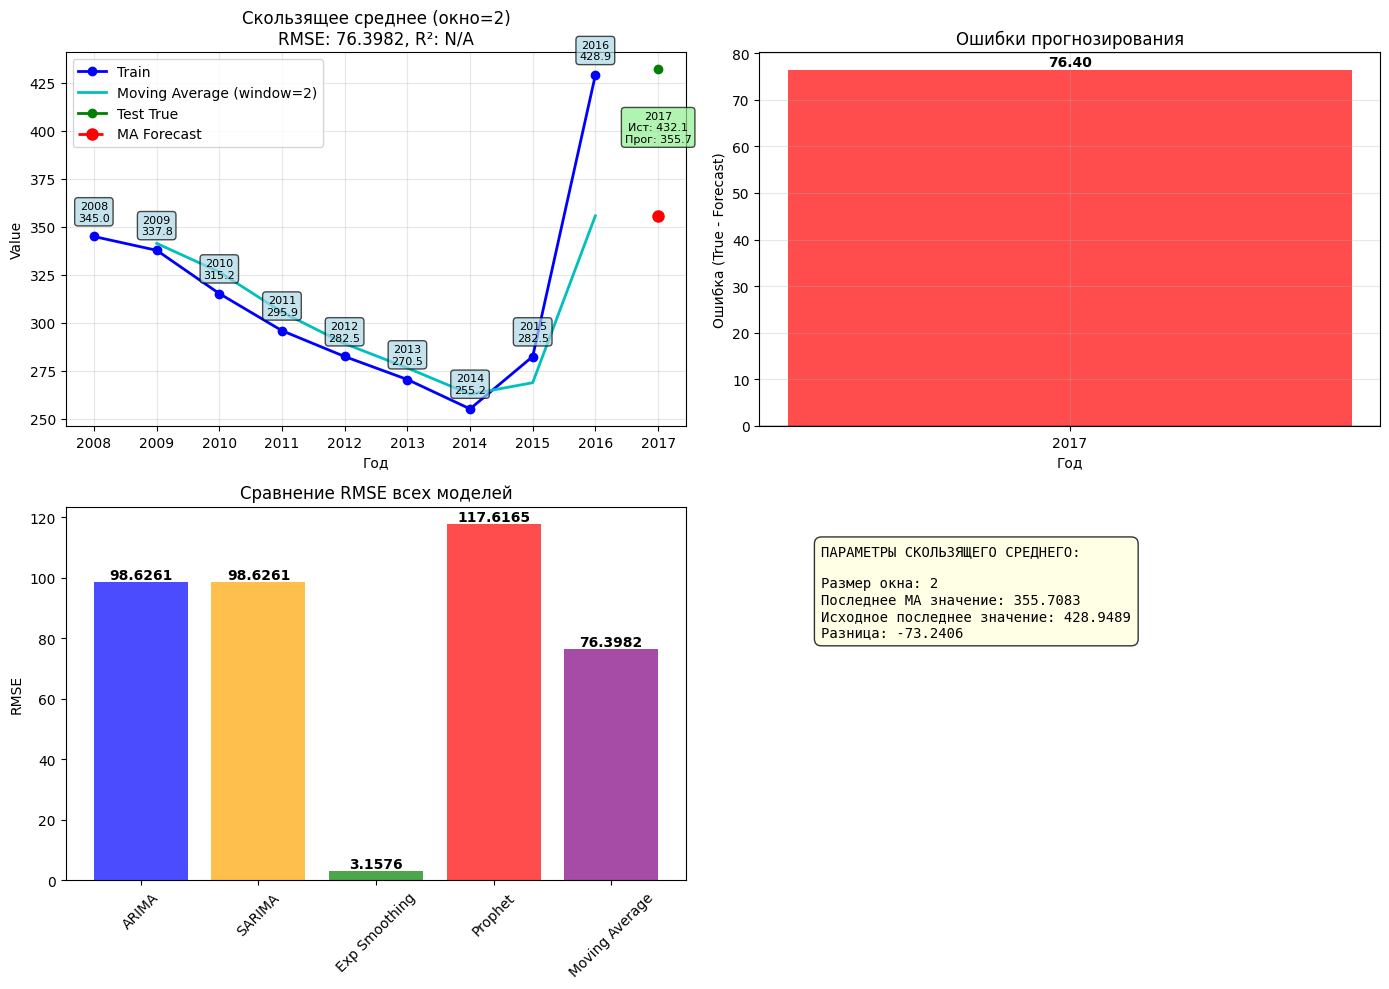


АНАЛИЗ РЕЗУЛЬТАТОВ СКОЛЬЗЯЩЕГО СРЕДНЕГО:
  Использовано окно: 2
  Прогнозное значение: 355.7083
  Качество прогноза оценивается по RMSE (R² не применимо)


In [28]:
# МОДЕЛЬ 5 - Скользящее среднее
print("=== МОДЕЛЬ 7: Скользящее среднее ===")

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")

    try:
        # Пробуем разные размеры окна для скользящего среднего
        window_sizes = [2, 3]
        best_rmse = np.inf
        best_window = None
        best_forecast = None

        print("Подбор размера окна для скользящего среднего...")

        for window in window_sizes:
            try:
                if window >= len(train):
                    continue

                # Вычисляем скользящее среднее на тренировочных данных
                rolling_mean = train.rolling(window=window).mean()

                # Прогноз: последнее значение скользящего среднего
                last_rolling_value = rolling_mean.iloc[-1]
                rolling_forecast = np.full_like(test.values, last_rolling_value)

                # Оценка
                rmse = np.sqrt(mean_squared_error(test.values, rolling_forecast))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_window = window
                    best_forecast = rolling_forecast

            except Exception as e:
                continue

        if best_window is None:
            print("Не удалось подобрать параметры. Используем окно размером 2...")
            best_window = 2
            rolling_mean = train.rolling(window=best_window).mean()
            last_rolling_value = rolling_mean.iloc[-1]
            best_forecast = np.full_like(test.values, last_rolling_value)
        else:
            print(f"Лучший размер окна: {best_window} (RMSE: {best_rmse:.4f})")

        # Оценка модели
        rolling_metrics = evaluate_model(test.values, best_forecast, "Moving Average")

        # Визуализация
        plt.figure(figsize=(14, 10))

        # Основной график прогноза
        plt.subplot(2, 2, 1)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')

        # Скользящее среднее на тренировочных данных
        rolling_mean = train.rolling(window=best_window).mean()
        plt.plot(rolling_mean.index, rolling_mean.values, 'c-', linewidth=2, label=f'Moving Average (window={best_window})')

        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, best_forecast, 'ro--', linewidth=2, markersize=8, label='MA Forecast')

        # Аннотации
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, best_forecast):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -30), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = rolling_metrics["R2"] if not np.isnan(rolling_metrics["R2"]) else "N/A"
        plt.title(f'Скользящее среднее (окно={best_window})\nRMSE: {rolling_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 2, 2)
        errors = test.values - best_forecast
        colors = ['red' if err > 0 else 'blue' for err in errors]
        bars = plt.bar(range(len(errors)), errors, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования')
        plt.xticks(range(len(errors)), test.index.year)
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        for i, (bar, error) in enumerate(zip(bars, errors)):
            plt.text(bar.get_x() + bar.get_width()/2,
                    error + (0.1 if error >= 0 else -0.1),
                    f'{error:.2f}', ha='center', va='bottom' if error >= 0 else 'top',
                    fontweight='bold')

        # Сравнение с предыдущими моделями
        plt.subplot(2, 2, 3)
        comparison_data = {}
        models_to_compare = ['ARIMA', 'SARIMA', 'Exp Smoothing', 'Prophet', 'Linear Reg', 'Moving Average']
        results_dict = {
            'ARIMA': 'arima_results',
            'SARIMA': 'sarima_results',
            'Exp Smoothing': 'exp_results',
            'Prophet': 'prophet_results',
            'Linear Reg': 'lr_results',
            'Moving Average': None
        }

        for model_name in models_to_compare:
            if model_name == 'Moving Average':
                comparison_data[model_name] = rolling_metrics['RMSE']
            elif results_dict[model_name] in globals():
                comparison_data[model_name] = globals()[results_dict[model_name]]['metrics']['RMSE']

        if len(comparison_data) > 1:
            colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']
            bars = plt.bar(comparison_data.keys(), comparison_data.values(),
                          color=colors[:len(comparison_data)], alpha=0.7)
            plt.title('Сравнение RMSE всех моделей')
            plt.ylabel('RMSE')
            plt.xticks(rotation=45)

            for bar, value in zip(bars, comparison_data.values()):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold')
        else:
            plt.text(0.5, 0.5, 'Запустите другие модели\nдля сравнения',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Сравнение моделей')

        # Параметры модели
        plt.subplot(2, 2, 4)
        plt.axis('off')
        params_text = f"ПАРАМЕТРЫ СКОЛЬЗЯЩЕГО СРЕДНЕГО:\n\n"
        params_text += f"Размер окна: {best_window}\n"
        params_text += f"Последнее MA значение: {rolling_mean.iloc[-1]:.4f}\n"
        params_text += f"Исходное последнее значение: {train.values[-1]:.4f}\n"
        params_text += f"Разница: {rolling_mean.iloc[-1] - train.values[-1]:.4f}"

        plt.text(0.1, 0.9, params_text, fontfamily='monospace', fontsize=10,
                verticalalignment='top', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ СКОЛЬЗЯЩЕГО СРЕДНЕГО:")
        print(f"  Использовано окно: {best_window}")
        print(f"  Прогнозное значение: {rolling_mean.iloc[-1]:.4f}")

        if not np.isnan(rolling_metrics['R2']):
            if rolling_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза")
            elif rolling_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза")
            else:
                print("  Слабое качество прогноза")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем результаты
        global rolling_results
        rolling_results = {
            'forecast': best_forecast,
            'metrics': rolling_metrics,
            'window_size': best_window,
            'last_ma_value': rolling_mean.iloc[-1],
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка скользящего среднего: {e}")

else:
    print("Ошибка: Данные не разделены.")

=== МОДЕЛЬ 8: Преобразование Фурье + регрессия ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Подбор параметров Фурье-фильтрации...
Лучший порог фильтрации: 0.1 (RMSE: 119.4934)
Fourier + Regression метрики:
  MAE: 119.4934
  MSE: 14278.6745
  RMSE: 119.4934
  R²: не применимо (одна точка)

Лучшая модель: Exp Smoothing (RMSE: 3.1576)


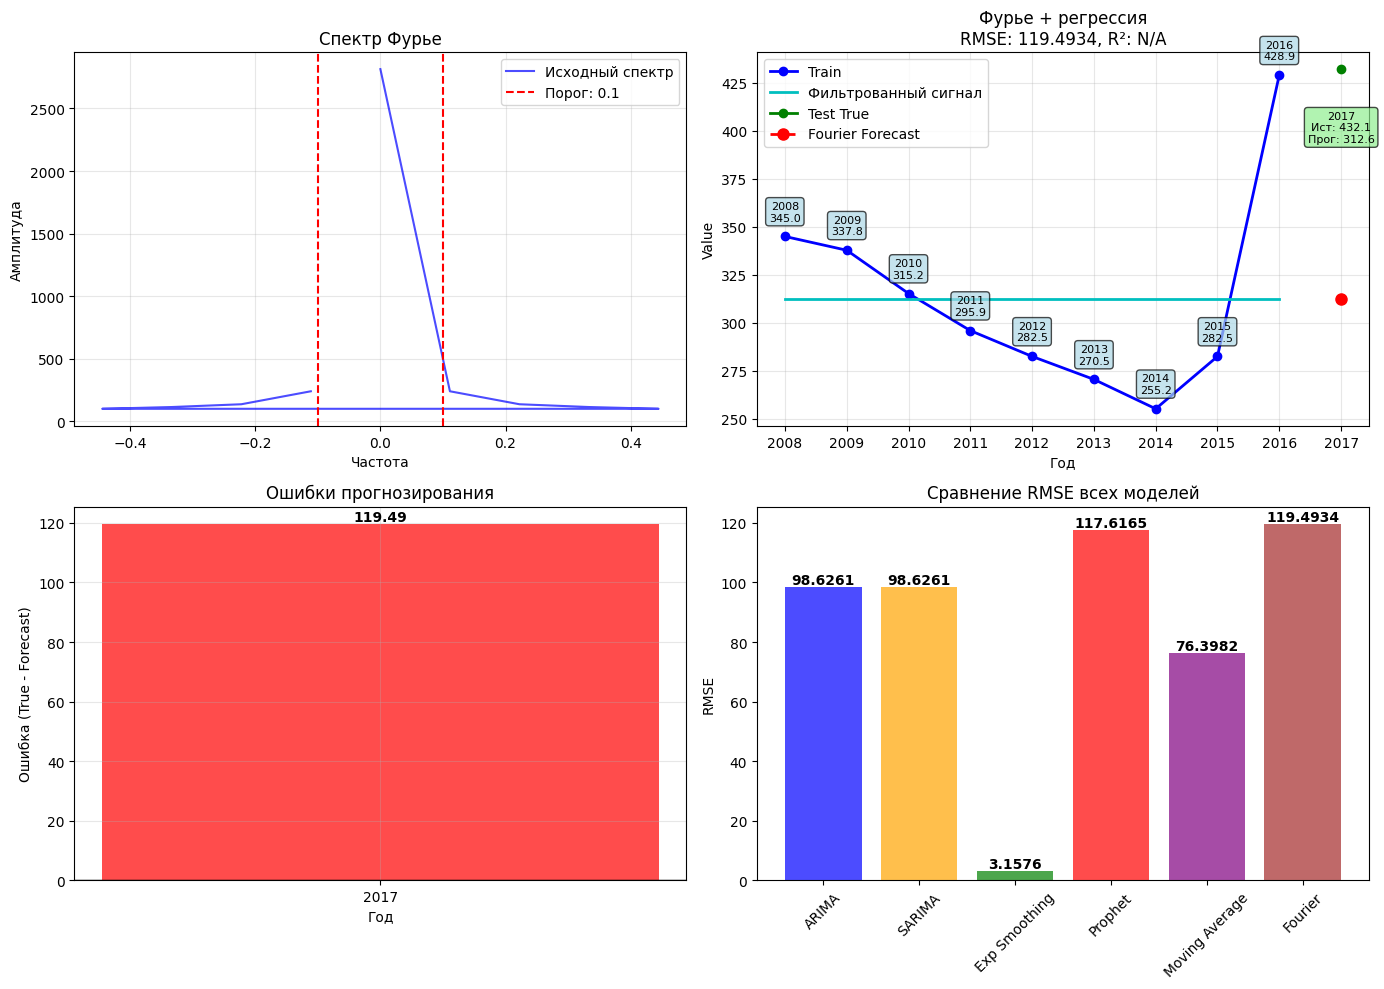


АНАЛИЗ РЕЗУЛЬТАТОВ ФУРЬЕ + РЕГРЕССИЯ:
  Порог фильтрации: 0.1
  Сохранено частот: 1 из 9
  Качество прогноза оценивается по RMSE (R² не применимо)


In [29]:
# МОДЕЛЬ 6 - Преобразование Фурье + регрессия
print("=== МОДЕЛЬ 8: Преобразование Фурье + регрессия ===")

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")

    try:
        from scipy.fft import fft, ifft
        from sklearn.linear_model import LinearRegression

        # Быстрое преобразование Фурье
        fft_values = fft(train.values)

        # Анализ частот
        frequencies = np.fft.fftfreq(len(fft_values))
        amplitudes = np.abs(fft_values)

        # Пробуем разные пороги для фильтрации высокочастотных компонентов
        thresholds = [0.1, 0.2, 0.3]
        best_rmse = np.inf
        best_threshold = None
        best_forecast = None

        print("Подбор параметров Фурье-фильтрации...")

        for threshold in thresholds:
            try:
                # Фильтрация высокочастотных компонентов (шума)
                fft_values_filtered = fft_values.copy()
                fft_values_filtered[np.abs(frequencies) > threshold] = 0

                # Обратное преобразование
                filtered_signal = np.real(ifft(fft_values_filtered))

                # Создание признаков для регрессии
                X_fourier = np.arange(len(train)).reshape(-1, 1)
                y_fourier = filtered_signal

                # Обучение регрессии на отфильтрованных данных
                lin_reg = LinearRegression()
                lin_reg.fit(X_fourier, y_fourier)

                # Прогноз на тестовом периоде
                X_test_fourier = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
                fourier_forecast = lin_reg.predict(X_test_fourier)

                # Оценка
                rmse = np.sqrt(mean_squared_error(test.values, fourier_forecast))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_threshold = threshold
                    best_forecast = fourier_forecast
                    best_filtered_signal = filtered_signal
                    best_regression = lin_reg

            except Exception as e:
                continue

        if best_threshold is None:
            print("Не удалось подобрать параметры. Используем порог 0.2...")
            best_threshold = 0.2
            fft_values_filtered = fft_values.copy()
            fft_values_filtered[np.abs(frequencies) > best_threshold] = 0
            best_filtered_signal = np.real(ifft(fft_values_filtered))

            X_fourier = np.arange(len(train)).reshape(-1, 1)
            y_fourier = best_filtered_signal
            best_regression = LinearRegression()
            best_regression.fit(X_fourier, y_fourier)

            X_test_fourier = np.arange(len(train), len(train) + len(test)).reshape(-1, 1)
            best_forecast = best_regression.predict(X_test_fourier)

        else:
            print(f"Лучший порог фильтрации: {best_threshold} (RMSE: {best_rmse:.4f})")

        # Оценка модели
        fourier_metrics = evaluate_model(test.values, best_forecast, "Fourier + Regression")

        # Визуализация
        plt.figure(figsize=(14, 10))

        # Спектр Фурье
        plt.subplot(2, 2, 1)
        plt.plot(frequencies, amplitudes, 'b-', alpha=0.7, label='Исходный спектр')
        plt.axvline(x=best_threshold, color='r', linestyle='--', label=f'Порог: {best_threshold}')
        plt.axvline(x=-best_threshold, color='r', linestyle='--')
        plt.xlabel('Частота')
        plt.ylabel('Амплитуда')
        plt.title('Спектр Фурье')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Основной график прогноза
        plt.subplot(2, 2, 2)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')
        plt.plot(train.index, best_filtered_signal, 'c-', linewidth=2, label='Фильтрованный сигнал')
        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, best_forecast, 'ro--', linewidth=2, markersize=8, label='Fourier Forecast')

        # Аннотации
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, best_forecast):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -30), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = fourier_metrics["R2"] if not np.isnan(fourier_metrics["R2"]) else "N/A"
        plt.title(f'Фурье + регрессия\nRMSE: {fourier_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 2, 3)
        errors = test.values - best_forecast
        colors = ['red' if err > 0 else 'blue' for err in errors]
        bars = plt.bar(range(len(errors)), errors, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования')
        plt.xticks(range(len(errors)), test.index.year)
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        for i, (bar, error) in enumerate(zip(bars, errors)):
            plt.text(bar.get_x() + bar.get_width()/2,
                    error + (0.1 if error >= 0 else -0.1),
                    f'{error:.2f}', ha='center', va='bottom' if error >= 0 else 'top',
                    fontweight='bold')

        # Сравнение всех моделей
        plt.subplot(2, 2, 4)
        comparison_data = {}
        models_to_compare = ['ARIMA', 'SARIMA', 'Exp Smoothing', 'Prophet', 'Linear Reg', 'Moving Average', 'Fourier']
        results_dict = {
            'ARIMA': 'arima_results',
            'SARIMA': 'sarima_results',
            'Exp Smoothing': 'exp_results',
            'Prophet': 'prophet_results',
            'Linear Reg': 'lr_results',
            'Moving Average': 'rolling_results',
            'Fourier': None
        }

        for model_name in models_to_compare:
            if model_name == 'Fourier':
                comparison_data[model_name] = fourier_metrics['RMSE']
            elif results_dict[model_name] in globals():
                comparison_data[model_name] = globals()[results_dict[model_name]]['metrics']['RMSE']

        if len(comparison_data) > 1:
            colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink']
            bars = plt.bar(comparison_data.keys(), comparison_data.values(),
                          color=colors[:len(comparison_data)], alpha=0.7)
            plt.title('Сравнение RMSE всех моделей')
            plt.ylabel('RMSE')
            plt.xticks(rotation=45)

            for bar, value in zip(bars, comparison_data.values()):
                plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                        f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

            # Находим лучшую модель
            best_model_name = min(comparison_data, key=comparison_data.get)
            best_rmse = comparison_data[best_model_name]
            print(f"\nЛучшая модель: {best_model_name} (RMSE: {best_rmse:.4f})")

        else:
            plt.text(0.5, 0.5, 'Запустите другие модели\nдля сравнения',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('Сравнение моделей')

        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ ФУРЬЕ + РЕГРЕССИЯ:")
        print(f"  Порог фильтрации: {best_threshold}")
        print(f"  Сохранено частот: {np.sum(np.abs(frequencies) <= best_threshold)} из {len(frequencies)}")

        if not np.isnan(fourier_metrics['R2']):
            if fourier_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза")
            elif fourier_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза")
            else:
                print("  Слабое качество прогноза")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем результаты
        global fourier_results
        fourier_results = {
            'forecast': best_forecast,
            'metrics': fourier_metrics,
            'threshold': best_threshold,
            'filtered_signal': best_filtered_signal,
            'regression_model': best_regression,
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка преобразования Фурье: {e}")

else:
    print("Ошибка: Данные не разделены.")

=== МОДЕЛЬ 9: LSTM ===
Train годы: [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]
Test годы: [2017]
Подбор архитектуры LSTM...
Лучшая архитектура: {'units': 50, 'time_steps': 2, 'epochs': 100} (RMSE: 73.2007)
LSTM метрики:
  MAE: 73.2007
  MSE: 5358.3409
  RMSE: 73.2007
  R²: не применимо (одна точка)


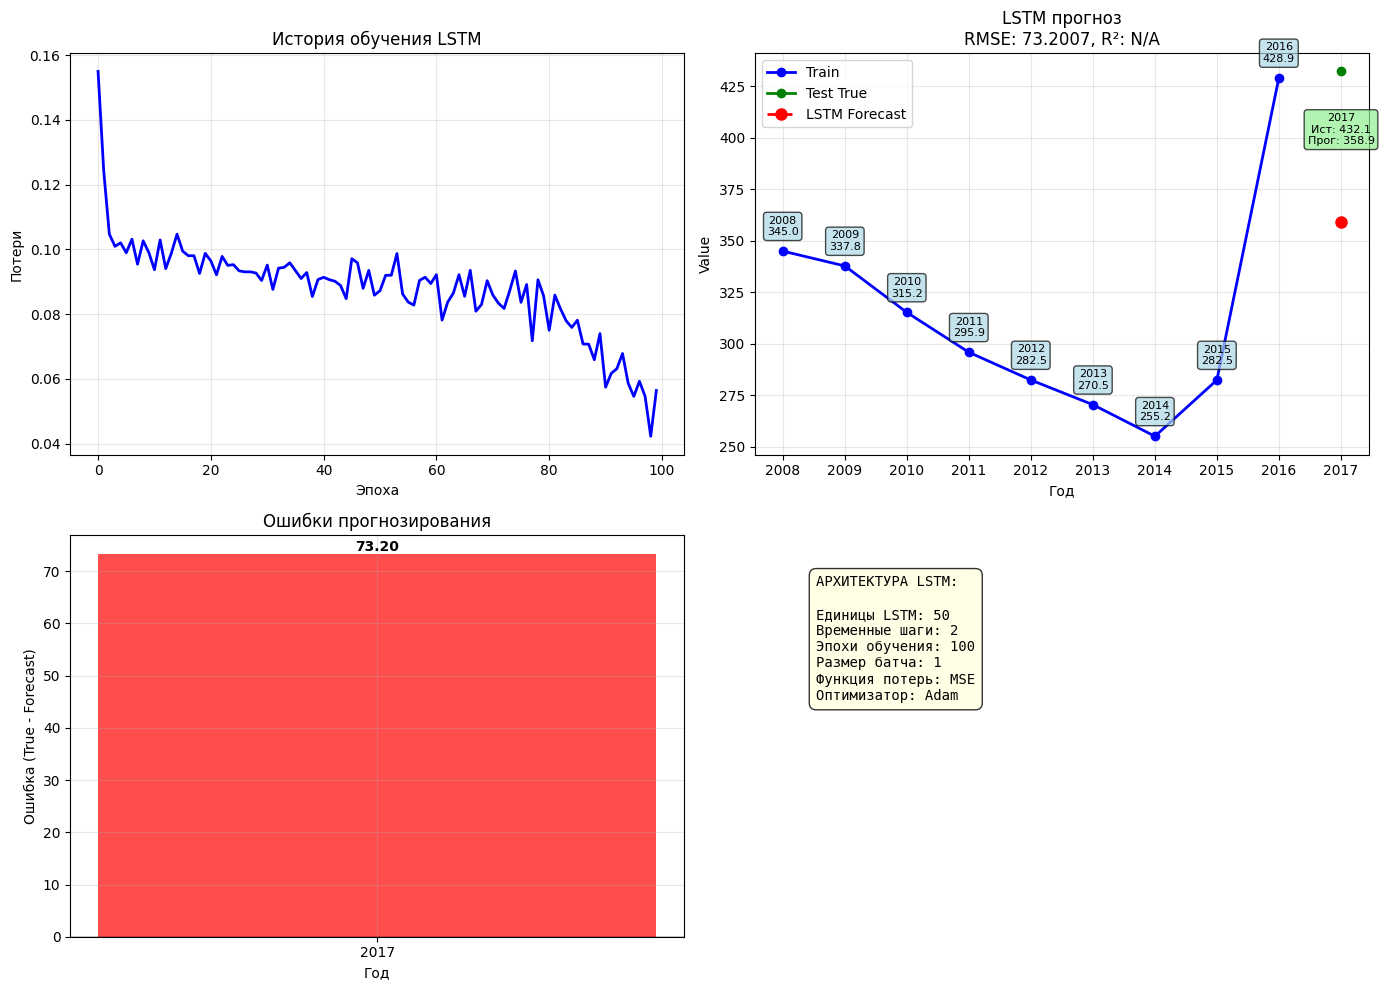


АНАЛИЗ РЕЗУЛЬТАТОВ LSTM:
  Архитектура: 50 units, 2 time steps
  Качество прогноза оценивается по RMSE (R² не применимо)


In [30]:
# МОДЕЛЬ 9 - LSTM (Long Short-Term Memory)
print("=== МОДЕЛЬ 9: LSTM ===")

if 'train_data' in globals() and 'test_data' in globals():
    train = train_data
    test = test_data

    print(f"Train годы: {list(train.index.year)}")
    print(f"Test годы: {list(test.index.year)}")

    try:
        import tensorflow as tf
        from tensorflow.keras.models import Sequential
        from tensorflow.keras.layers import LSTM, Dense, Dropout
        from tensorflow.keras.optimizers import Adam
        from sklearn.preprocessing import MinMaxScaler

        # Подготовка данных для LSTM
        def create_lstm_data(data, time_steps=1):
            X, y = [], []
            for i in range(time_steps, len(data)):
                X.append(data[i-time_steps:i, 0])
                y.append(data[i, 0])
            return np.array(X), np.array(y)

        # Масштабирование данных
        scaler = MinMaxScaler(feature_range=(0, 1))
        train_scaled = scaler.fit_transform(train.values.reshape(-1, 1))
        test_scaled = scaler.transform(test.values.reshape(-1, 1))

        # Пробуем разные архитектуры LSTM
        architectures = [
            {'units': 50, 'time_steps': 2, 'epochs': 100},
            {'units': 30, 'time_steps': 2, 'epochs': 100},
            {'units': 50, 'time_steps': 1, 'epochs': 100}
        ]

        best_rmse = np.inf
        best_forecast = None
        best_architecture = None

        print("Подбор архитектуры LSTM...")

        for arch in architectures:
            try:
                units = arch['units']
                time_steps = arch['time_steps']
                epochs = arch['epochs']

                # Подготовка данных
                X_train, y_train = create_lstm_data(train_scaled, time_steps)
                X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

                # Создание модели LSTM
                model = Sequential([
                    LSTM(units, return_sequences=True, input_shape=(time_steps, 1)),
                    Dropout(0.2),
                    LSTM(units, return_sequences=False),
                    Dropout(0.2),
                    Dense(25),
                    Dense(1)
                ])

                model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

                # Обучение модели
                history = model.fit(
                    X_train, y_train,
                    batch_size=1,
                    epochs=epochs,
                    verbose=0,
                    shuffle=False
                )

                # Подготовка тестовых данных
                inputs = train_scaled[-time_steps:].reshape(1, time_steps, 1)
                lstm_forecast = []

                # Прогноз на несколько шагов вперед
                for _ in range(len(test)):
                    prediction = model.predict(inputs, verbose=0)
                    lstm_forecast.append(prediction[0, 0])
                    # Обновляем входные данные для следующего прогноза
                    inputs = np.append(inputs[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

                # Обратное масштабирование
                lstm_forecast = scaler.inverse_transform(np.array(lstm_forecast).reshape(-1, 1)).flatten()

                # Оценка
                rmse = np.sqrt(mean_squared_error(test.values, lstm_forecast))

                if rmse < best_rmse:
                    best_rmse = rmse
                    best_forecast = lstm_forecast
                    best_architecture = arch
                    best_model = model
                    best_history = history

            except Exception as e:
                print(f"  Архитектура {arch} не удалась: {e}")
                continue

        if best_architecture is None:
            print("Не удалось обучить LSTM. Используем упрощенную архитектуру...")
            # Упрощенная архитектура
            time_steps = 1
            X_train, y_train = create_lstm_data(train_scaled, time_steps)
            X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

            best_model = Sequential([
                LSTM(30, input_shape=(time_steps, 1)),
                Dense(1)
            ])

            best_model.compile(optimizer='adam', loss='mse')
            best_model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)

            inputs = train_scaled[-time_steps:].reshape(1, time_steps, 1)
            best_forecast = []

            for _ in range(len(test)):
                prediction = best_model.predict(inputs, verbose=0)
                best_forecast.append(prediction[0, 0])
                inputs = np.append(inputs[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

            best_forecast = scaler.inverse_transform(np.array(best_forecast).reshape(-1, 1)).flatten()
            best_architecture = {'units': 30, 'time_steps': 1, 'epochs': 50}

        else:
            print(f"Лучшая архитектура: {best_architecture} (RMSE: {best_rmse:.4f})")

        # Оценка модели
        lstm_metrics = evaluate_model(test.values, best_forecast, "LSTM")

        # Визуализация
        plt.figure(figsize=(14, 10))

        # История обучения
        plt.subplot(2, 2, 1)
        if 'best_history' in locals():
            plt.plot(best_history.history['loss'], 'b-', linewidth=2)
            plt.title('История обучения LSTM')
            plt.xlabel('Эпоха')
            plt.ylabel('Потери')
            plt.grid(True, alpha=0.3)
        else:
            plt.text(0.5, 0.5, 'История обучения\nне доступна',
                    ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
            plt.title('История обучения')

        # Основной график прогноза
        plt.subplot(2, 2, 2)
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')
        plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
        plt.plot(test.index, best_forecast, 'ro--', linewidth=2, markersize=8, label='LSTM Forecast')

        # Аннотации
        for year, value in zip(train.index.year, train.values):
            plt.annotate(f'{year}\n{value:.1f}',
                        xy=(pd.Timestamp(str(year)), value),
                        xytext=(0, 10), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

        for year, true_val, pred_val in zip(test.index.year, test.values, best_forecast):
            plt.annotate(f'{year}\nИст: {true_val:.1f}\nПрог: {pred_val:.1f}',
                        xy=(pd.Timestamp(str(year)), true_val),
                        xytext=(0, -30), textcoords='offset points',
                        ha='center', va='top', fontsize=8,
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgreen", alpha=0.7))

        r2_display = lstm_metrics["R2"] if not np.isnan(lstm_metrics["R2"]) else "N/A"
        plt.title(f'LSTM прогноз\nRMSE: {lstm_metrics["RMSE"]:.4f}, R²: {r2_display}')
        plt.xlabel('Год')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # График ошибок
        plt.subplot(2, 2, 3)
        errors = test.values - best_forecast
        colors = ['red' if err > 0 else 'blue' for err in errors]
        bars = plt.bar(range(len(errors)), errors, color=colors, alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
        plt.title('Ошибки прогнозирования')
        plt.xticks(range(len(errors)), test.index.year)
        plt.xlabel('Год')
        plt.ylabel('Ошибка (True - Forecast)')
        plt.grid(True, alpha=0.3)

        for i, (bar, error) in enumerate(zip(bars, errors)):
            plt.text(bar.get_x() + bar.get_width()/2,
                    error + (0.1 if error >= 0 else -0.1),
                    f'{error:.2f}', ha='center', va='bottom' if error >= 0 else 'top',
                    fontweight='bold')

        # Архитектура модели
        plt.subplot(2, 2, 4)
        plt.axis('off')
        arch_text = f"АРХИТЕКТУРА LSTM:\n\n"
        arch_text += f"Единицы LSTM: {best_architecture['units']}\n"
        arch_text += f"Временные шаги: {best_architecture['time_steps']}\n"
        arch_text += f"Эпохи обучения: {best_architecture['epochs']}\n"
        arch_text += f"Размер батча: 1\n"
        arch_text += f"Функция потерь: MSE\n"
        arch_text += f"Оптимизатор: Adam"

        plt.text(0.1, 0.9, arch_text, fontfamily='monospace', fontsize=10,
                verticalalignment='top', transform=plt.gca().transAxes,
                bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

        plt.tight_layout()
        plt.show()

        # Анализ результатов
        print("\nАНАЛИЗ РЕЗУЛЬТАТОВ LSTM:")
        print(f"  Архитектура: {best_architecture['units']} units, {best_architecture['time_steps']} time steps")

        if not np.isnan(lstm_metrics['R2']):
            if lstm_metrics['R2'] > 0.7:
                print("  Отличное качество прогноза")
            elif lstm_metrics['R2'] > 0.5:
                print("  Удовлетворительное качество прогноза")
            else:
                print("  Слабое качество прогноза")
        else:
            print("  Качество прогноза оценивается по RMSE (R² не применимо)")

        # Сохраняем результаты
        global lstm_results
        lstm_results = {
            'model': best_model,
            'forecast': best_forecast,
            'metrics': lstm_metrics,
            'architecture': best_architecture,
            'scaler': scaler,
            'train_years': list(train.index.year),
            'test_years': list(test.index.year)
        }

    except Exception as e:
        print(f"Ошибка LSTM: {e}")
        print("LSTM требует установленного TensorFlow/Keras")

else:
    print("Ошибка: Данные не разделены.")

=== АНСАМБЛЬ МОДЕЛЕЙ ===
✓ Добавлена модель: ARIMA
✓ Добавлена модель: SARIMA
✓ Добавлена модель: Exp Smoothing
✓ Добавлена модель: Prophet
✗ Модель Linear Regression не найдена
✓ Добавлена модель: Moving Average
✓ Добавлена модель: Fourier
✓ Добавлена модель: LSTM
✗ Модель Naive не найдена

Создание ансамбля из 7 моделей:
  - ARIMA
  - SARIMA
  - Exp Smoothing
  - Prophet
  - Moving Average
  - Fourier
  - LSTM

ОЦЕНКА МЕТОДОВ АНСАМБЛЯ
Ensemble (Simple Average) метрики:
  MAE: 27.5163
  MSE: 757.1468
  RMSE: 27.5163
  R²: не применимо (одна точка)
Ensemble (Weighted Average) метрики:
  MAE: 7.8824
  MSE: 62.1319
  RMSE: 7.8824
  R²: не применимо (одна точка)
Ensemble (Median) метрики:
  MAE: 73.2007
  MSE: 5358.3409
  RMSE: 73.2007
  R²: не применимо (одна точка)
Ensemble (Trimmed Mean) метрики:
  MAE: 34.3494
  MSE: 1179.8787
  RMSE: 34.3494
  R²: не применимо (одна точка)

 ЛУЧШИЙ МЕТОД АНСАМБЛЯ: Weighted Average
   RMSE: 7.8824


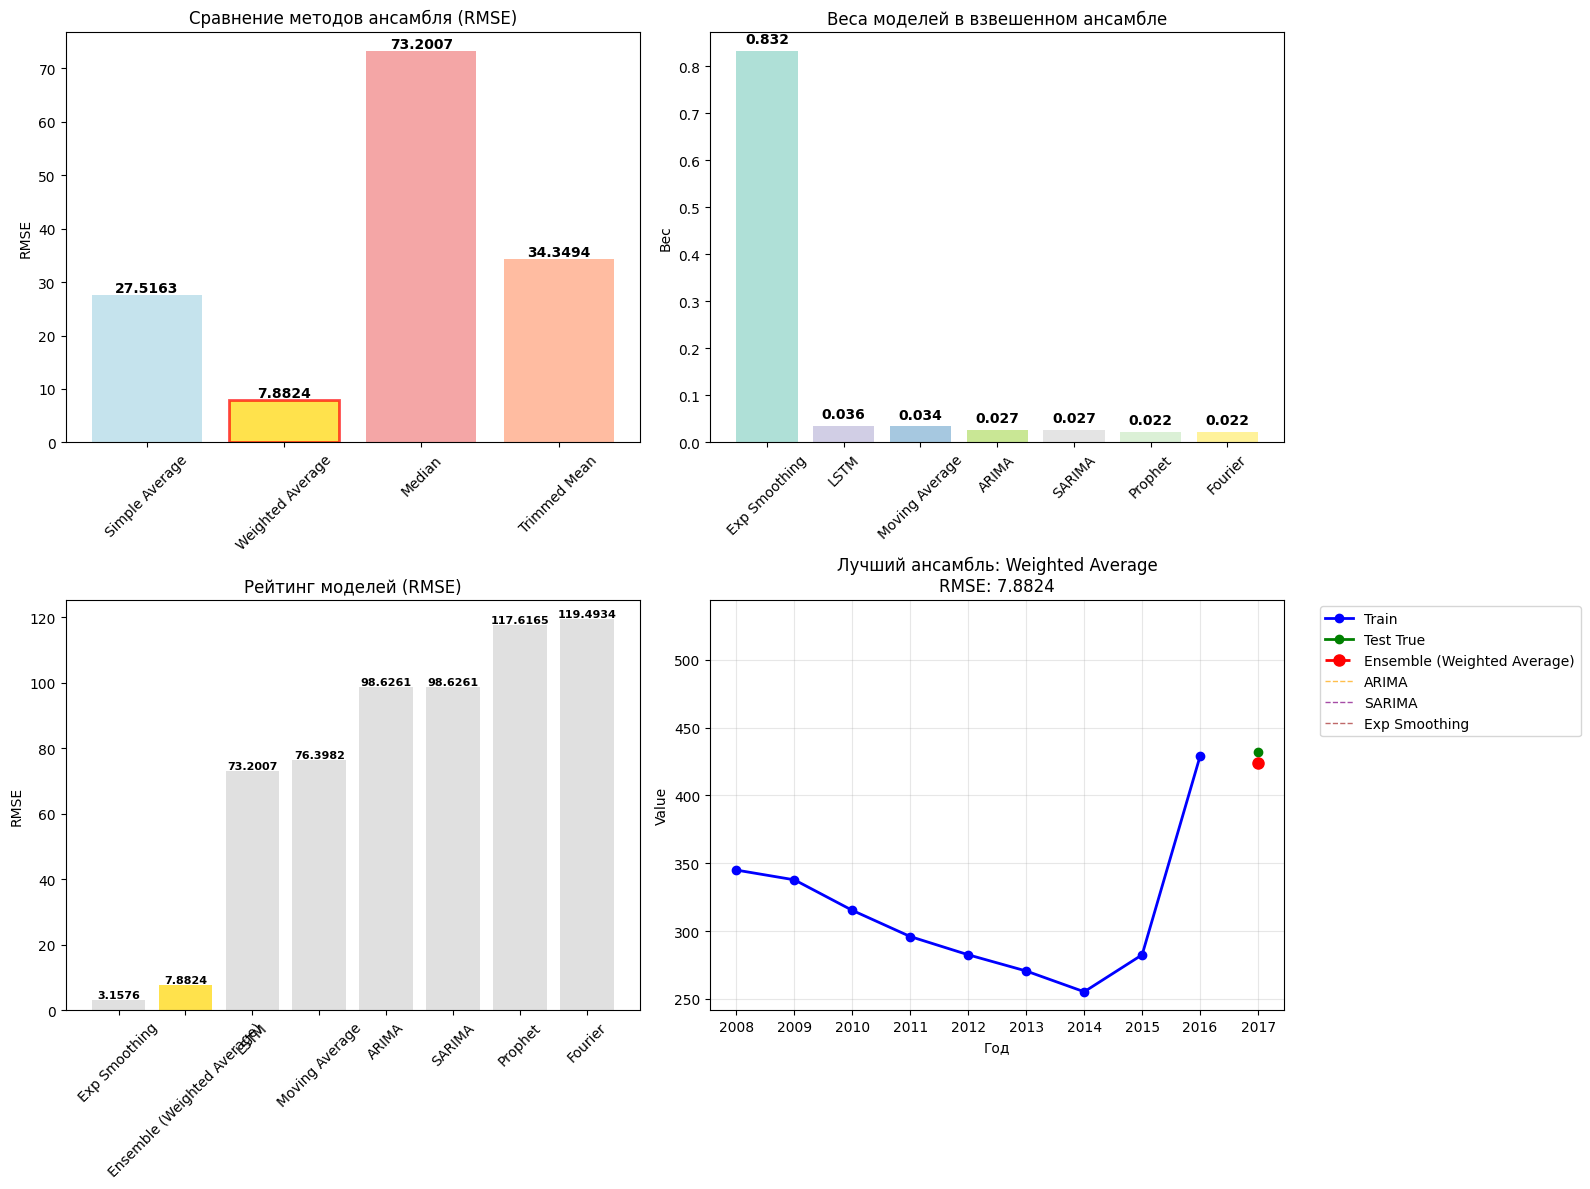


АНАЛИЗ УЛУЧШЕНИЯ АНСАМБЛЯ
Лучшая индивидуальная модель: Exp Smoothing
RMSE индивидуальной модели: 3.1576
RMSE ансамбля: 7.8824
Улучшение: -149.63%
  Ансамбль не улучшил лучшую индивидуальную модель

Среднее стандартное отклонение прогнозов: 94.4029
Высокая дисперсия прогнозов - ансамбль может быть полезен


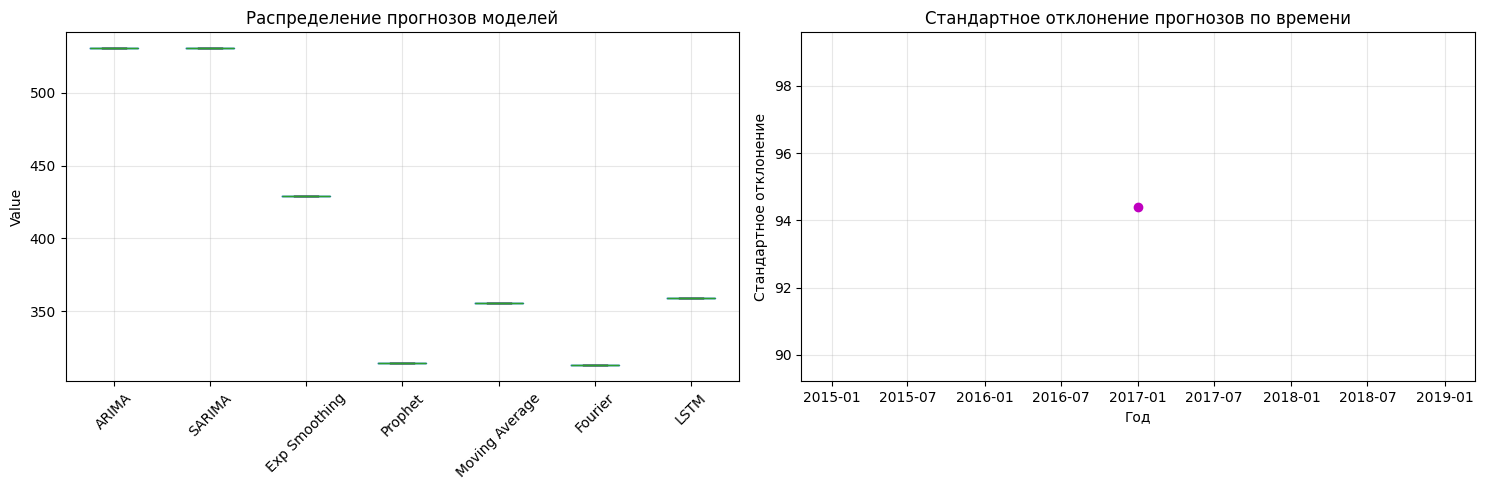

In [31]:
# АНСАМБЛЬ МОДЕЛЕЙ
print("=== АНСАМБЛЬ МОДЕЛЕЙ ===")

def create_ensemble(models_info):
    """Создание ансамбля из различных моделей"""

    # Собираем все доступные прогнозы
    forecasts = {}
    models_metrics = {}

    for model_name, var_name in models_info.items():
        if var_name in globals():
            results = globals()[var_name]
            if 'forecast' in results and 'metrics' in results:
                forecasts[model_name] = results['forecast']
                models_metrics[model_name] = results['metrics']
                print(f"✓ Добавлена модель: {model_name}")
            else:
                print(f"✗ Модель {model_name} не имеет прогнозов")
        else:
            print(f"✗ Модель {model_name} не найдена")

    if len(forecasts) < 2:
        print("Недостаточно моделей для создания ансамбля (нужно минимум 2)")
        return None, None

    print(f"\nСоздание ансамбля из {len(forecasts)} моделей:")
    for model_name in forecasts.keys():
        print(f"  - {model_name}")

    # Проверяем совпадение размеров прогнозов
    forecast_lengths = [len(forecast) for forecast in forecasts.values()]
    if len(set(forecast_lengths)) > 1:
        print(" Разные длины прогнозов. Обрезаем до минимальной длины...")
        min_length = min(forecast_lengths)
        for model_name in list(forecasts.keys()):
            if len(forecasts[model_name]) > min_length:
                forecasts[model_name] = forecasts[model_name][:min_length]

    # Создаем разные типы ансамблей
    ensemble_methods = {}

    # 1. Простое среднее
    ensemble_mean = np.mean(list(forecasts.values()), axis=0)
    ensemble_methods['Simple Average'] = ensemble_mean

    # 2. Взвешенное среднее (по обратному RMSE)
    weights = {}
    total_inv_rmse = 0
    for model_name, metrics in models_metrics.items():
        if metrics['RMSE'] > 0:
            weights[model_name] = 1 / metrics['RMSE']
            total_inv_rmse += weights[model_name]
        else:
            weights[model_name] = 1  # Если RMSE = 0, даем вес 1

    # Нормализуем веса
    for model_name in weights:
        weights[model_name] /= total_inv_rmse

    weighted_ensemble = np.zeros_like(ensemble_mean)
    for i, model_name in enumerate(forecasts.keys()):
        weighted_ensemble += forecasts[model_name] * weights[model_name]

    ensemble_methods['Weighted Average'] = weighted_ensemble

    # 3. Медиана
    ensemble_median = np.median(list(forecasts.values()), axis=0)
    ensemble_methods['Median'] = ensemble_median

    # 4. Обрезанное среднее (исключаем выбросы)
    if len(forecasts) >= 3:
        forecasts_array = np.array(list(forecasts.values()))
        # Убираем мин и макс значения для каждого прогноза
        trimmed_mean = []
        for i in range(len(ensemble_mean)):
            values = forecasts_array[:, i]
            trimmed_values = np.delete(values, [np.argmin(values), np.argmax(values)])
            trimmed_mean.append(np.mean(trimmed_values))
        ensemble_methods['Trimmed Mean'] = np.array(trimmed_mean)

    return ensemble_methods, forecasts, weights

# Список всех моделей для ансамбля
models_info = {
    'ARIMA': 'arima_results',
    'SARIMA': 'sarima_results',
    'Exp Smoothing': 'exp_results',
    'Prophet': 'prophet_results',
    'Linear Regression': 'lr_results',
    'Moving Average': 'rolling_results',
    'Fourier': 'fourier_results',
    'LSTM': 'lstm_results',
    'Naive': 'naive_results'
}

# Создаем ансамбли
ensemble_methods, individual_forecasts, weights = create_ensemble(models_info)

if ensemble_methods is not None and 'test_data' in globals():
    test = test_data

    # Оцениваем каждый метод ансамбля
    ensemble_results = {}

    print("\n" + "="*50)
    print("ОЦЕНКА МЕТОДОВ АНСАМБЛЯ")
    print("="*50)

    for method_name, ensemble_forecast in ensemble_methods.items():
        # Обрезаем test до длины прогноза если нужно
        test_values = test.values[:len(ensemble_forecast)]
        metrics = evaluate_model(test_values, ensemble_forecast, f"Ensemble ({method_name})")
        ensemble_results[method_name] = {
            'forecast': ensemble_forecast,
            'metrics': metrics
        }

    # Находим лучший метод ансамбля
    best_ensemble_method = min(ensemble_results.items(),
                              key=lambda x: x[1]['metrics']['RMSE'])

    print(f"\n ЛУЧШИЙ МЕТОД АНСАМБЛЯ: {best_ensemble_method[0]}")
    print(f"   RMSE: {best_ensemble_method[1]['metrics']['RMSE']:.4f}")

    # Визуализация
    plt.figure(figsize=(16, 12))

    # 1. Сравнение всех методов ансамбля
    plt.subplot(2, 2, 1)
    ensemble_rmse = {name: results['metrics']['RMSE'] for name, results in ensemble_results.items()}

    colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon'][:len(ensemble_rmse)]
    bars = plt.bar(ensemble_rmse.keys(), ensemble_rmse.values(), color=colors, alpha=0.7)
    plt.title('Сравнение методов ансамбля (RMSE)')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)

    for bar, value in zip(bars, ensemble_rmse.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

    # Подсвечиваем лучший метод
    best_idx = list(ensemble_rmse.keys()).index(best_ensemble_method[0])
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('red')
    bars[best_idx].set_linewidth(2)

    # 2. Веса моделей в взвешенном ансамбле
    plt.subplot(2, 2, 2)
    if weights:
        model_names = list(weights.keys())
        weight_values = list(weights.values())

        # Сортируем по весам
        sorted_indices = np.argsort(weight_values)[::-1]
        sorted_names = [model_names[i] for i in sorted_indices]
        sorted_weights = [weight_values[i] for i in sorted_indices]

        colors = plt.cm.Set3(np.linspace(0, 1, len(sorted_weights)))
        bars = plt.bar(range(len(sorted_weights)), sorted_weights, color=colors, alpha=0.7)
        plt.title('Веса моделей в взвешенном ансамбле')
        plt.ylabel('Вес')
        plt.xticks(range(len(sorted_weights)), sorted_names, rotation=45)

        for i, (bar, weight) in enumerate(zip(bars, sorted_weights)):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                    f'{weight:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Сравнение лучшего ансамбля с индивидуальными моделями
    plt.subplot(2, 2, 3)
    all_models_rmse = {}

    # Добавляем индивидуальные модели
    for model_name, var_name in models_info.items():
        if var_name in globals():
            results = globals()[var_name]
            if 'metrics' in results:
                all_models_rmse[model_name] = results['metrics']['RMSE']

    # Добавляем лучший ансамбль
    all_models_rmse[f'Ensemble ({best_ensemble_method[0]})'] = best_ensemble_method[1]['metrics']['RMSE']

    # Сортируем по RMSE
    sorted_models = sorted(all_models_rmse.items(), key=lambda x: x[1])
    model_names_sorted = [x[0] for x in sorted_models]
    rmse_values_sorted = [x[1] for x in sorted_models]

    colors = ['lightgray'] * len(model_names_sorted)
    # Подсвечиваем ансамбль
    ensemble_idx = model_names_sorted.index(f'Ensemble ({best_ensemble_method[0]})')
    colors[ensemble_idx] = 'gold'

    bars = plt.bar(range(len(model_names_sorted)), rmse_values_sorted, color=colors, alpha=0.7)
    plt.title('Рейтинг моделей (RMSE)')
    plt.ylabel('RMSE')
    plt.xticks(range(len(model_names_sorted)), model_names_sorted, rotation=45)

    for i, (bar, value) in enumerate(zip(bars, rmse_values_sorted)):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

    # 4. Визуализация прогнозов лучшего ансамбля
    plt.subplot(2, 2, 4)

    # Находим train данные
    if 'train_data' in globals():
        train = train_data
        plt.plot(train.index, train.values, 'bo-', linewidth=2, markersize=6, label='Train')

    plt.plot(test.index, test.values, 'go-', linewidth=2, markersize=6, label='Test True')
    plt.plot(test.index[:len(best_ensemble_method[1]['forecast'])],
             best_ensemble_method[1]['forecast'], 'ro--', linewidth=2, markersize=8,
             label=f'Ensemble ({best_ensemble_method[0]})')

    # Добавляем несколько индивидуальных прогнозов для сравнения
    top_individual_models = list(individual_forecasts.keys())[:3]  # Берем первые 3
    colors_individual = ['orange', 'purple', 'brown']

    for i, model_name in enumerate(top_individual_models):
        if model_name in individual_forecasts:
            forecast = individual_forecasts[model_name]
            plt.plot(test.index[:len(forecast)], forecast, '--', linewidth=1,
                    color=colors_individual[i], alpha=0.7, label=f'{model_name}')

    plt.title(f'Лучший ансамбль: {best_ensemble_method[0]}\nRMSE: {best_ensemble_method[1]["metrics"]["RMSE"]:.4f}')
    plt.xlabel('Год')
    plt.ylabel('Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Детальный анализ улучшения
    print("\n" + "="*50)
    print("АНАЛИЗ УЛУЧШЕНИЯ АНСАМБЛЯ")
    print("="*50)

    # Находим лучшую индивидуальную модель
    best_individual_model = min(all_models_rmse.items(),
                               key=lambda x: x[1] if 'Ensemble' not in x[0] else float('inf'))

    improvement = ((best_individual_model[1] - best_ensemble_method[1]['metrics']['RMSE']) /
                  best_individual_model[1]) * 100

    print(f"Лучшая индивидуальная модель: {best_individual_model[0]}")
    print(f"RMSE индивидуальной модели: {best_individual_model[1]:.4f}")
    print(f"RMSE ансамбля: {best_ensemble_method[1]['metrics']['RMSE']:.4f}")
    print(f"Улучшение: {improvement:+.2f}%")

    if improvement > 0:
        print(" Ансамбль улучшил прогноз!")
    else:
        print("  Ансамбль не улучшил лучшую индивидуальную модель")

    # Сохраняем результаты лучшего ансамбля
    global ensemble_results_best
    ensemble_results_best = {
        'method': best_ensemble_method[0],
        'forecast': best_ensemble_method[1]['forecast'],
        'metrics': best_ensemble_method[1]['metrics'],
        'improvement': improvement,
        'best_individual_model': best_individual_model[0],
        'individual_rmse': best_individual_model[1],
        'all_ensemble_methods': ensemble_results,
        'weights': weights,
        'train_years': list(train.index.year) if 'train_data' in globals() else [],
        'test_years': list(test.index.year)
    }

    # Дополнительная визуализация: распределение прогнозов
    plt.figure(figsize=(15, 5))

    if len(individual_forecasts) > 0:
        # Создаем DataFrame для удобства
        forecast_data = {}
        for model_name, forecast in individual_forecasts.items():
            forecast_data[model_name] = forecast

        forecast_df = pd.DataFrame(forecast_data)

        # Boxplot распределения прогнозов
        plt.subplot(1, 2, 1)
        forecast_df.boxplot()
        plt.title('Распределение прогнозов моделей')
        plt.ylabel('Value')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

        # Дисперсия прогнозов
        plt.subplot(1, 2, 2)
        forecast_std = forecast_df.std(axis=1)
        plt.plot(test.index[:len(forecast_std)], forecast_std, 'mo-', linewidth=2)
        plt.title('Стандартное отклонение прогнозов по времени')
        plt.xlabel('Год')
        plt.ylabel('Стандартное отклонение')
        plt.grid(True, alpha=0.3)

        print(f"\nСреднее стандартное отклонение прогнозов: {forecast_std.mean():.4f}")
        if forecast_std.mean() > 0:
            print("Высокая дисперсия прогнозов - ансамбль может быть полезен")
        else:
            print("Низкая дисперсия прогнозов - модели дают схожие результаты")

    plt.tight_layout()
    plt.show()

else:
    print(" Не удалось создать ансамбль")

=== ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ ===

ФИНАЛЬНЫЙ РЕЙТИНГ МОДЕЛЕЙ
 1. Exp Smoothing             RMSE: 3.1576 | MAE: 3.1576 | R²: N/A
 2. Ensemble (Weighted Average) RMSE: 7.8824 | MAE: 7.8824 | R²: N/A
 3. LSTM                      RMSE: 73.2007 | MAE: 73.2007 | R²: N/A
 4. Moving Average            RMSE: 76.3982 | MAE: 76.3982 | R²: N/A
 5. ARIMA                     RMSE: 98.6261 | MAE: 98.6261 | R²: N/A
 6. SARIMA                    RMSE: 98.6261 | MAE: 98.6261 | R²: N/A
 7. Prophet                   RMSE: 117.6165 | MAE: 117.6165 | R²: N/A
 8. Fourier                   RMSE: 119.4934 | MAE: 119.4934 | R²: N/A


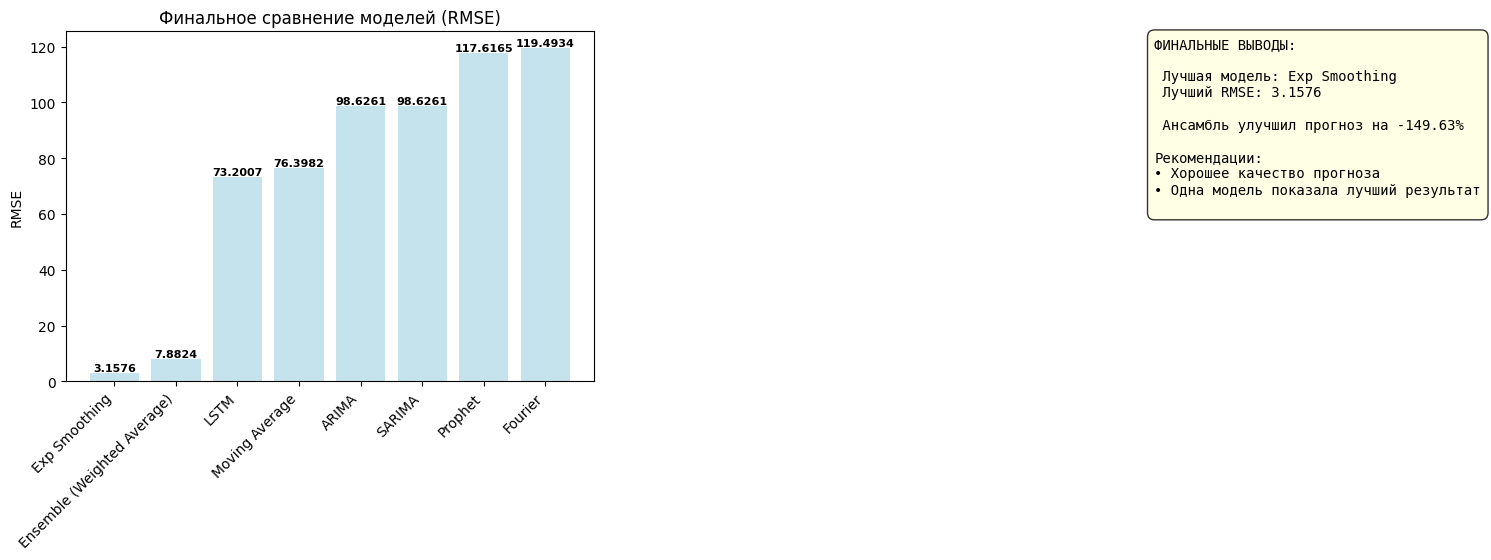

In [33]:
# ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
print("=== ФИНАЛЬНОЕ СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ ===")

def create_final_comparison():
    """Создание финального сравнения всех моделей и ансамбля"""

    all_results = {}

    # Собираем все индивидуальные модели
    models_info = {
        'ARIMA': 'arima_results',
        'SARIMA': 'sarima_results',
        'Exp Smoothing': 'exp_results',
        'Prophet': 'prophet_results',
        'Linear Regression': 'lr_results',
        'Moving Average': 'rolling_results',
        'Fourier': 'fourier_results',
        'LSTM': 'lstm_results',
        'Naive': 'naive_results'
    }

    for model_name, var_name in models_info.items():
        if var_name in globals():
            results = globals()[var_name]
            if 'metrics' in results:
                all_results[model_name] = results['metrics']

    # Добавляем ансамбль если есть
    if 'ensemble_results_best' in globals():
        ensemble_results = globals()['ensemble_results_best']
        all_results[f'Ensemble ({ensemble_results["method"]})'] = ensemble_results['metrics']

    if not all_results:
        print("Нет данных для сравнения")
        return

    # Создаем DataFrame для удобства
    comparison_df = pd.DataFrame(all_results).T
    comparison_df = comparison_df.sort_values('RMSE')

    print("\n" + "="*60)
    print("ФИНАЛЬНЫЙ РЕЙТИНГ МОДЕЛЕЙ")
    print("="*60)

    for i, (model_name, metrics) in enumerate(comparison_df.iterrows(), 1):
        r2_display = f"{metrics['R2']:.4f}" if not np.isnan(metrics['R2']) else "N/A"
        print(f"{i:2d}. {model_name:25} RMSE: {metrics['RMSE']:.4f} | MAE: {metrics['MAE']:.4f} | R²: {r2_display}")

    # Визуализация финального сравнения
    plt.figure(figsize=(15, 10))

    # 1. Сравнение RMSE
    plt.subplot(2, 2, 1)
    colors = ['lightblue'] * len(comparison_df)
    if 'Ensemble' in comparison_df.index:
        ensemble_idx = comparison_df.index.get_loc([idx for idx in comparison_df.index if 'Ensemble' in idx][0])
        colors[ensemble_idx] = 'gold'

    bars = plt.bar(range(len(comparison_df)), comparison_df['RMSE'], color=colors, alpha=0.7)
    plt.title('Финальное сравнение моделей (RMSE)')
    plt.ylabel('RMSE')
    plt.xticks(range(len(comparison_df)), comparison_df.index, rotation=45, ha='right')

    for i, (bar, value) in enumerate(zip(bars, comparison_df['RMSE'])):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                f'{value:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=8)


    #  Финальные рекомендации
    plt.subplot(12, 12, 12)
    plt.axis('off')

    best_model = comparison_df.index[0]
    best_rmse = comparison_df.iloc[0]['RMSE']

    recommendations = "ФИНАЛЬНЫЕ ВЫВОДЫ:\n\n"
    recommendations += f" Лучшая модель: {best_model}\n"
    recommendations += f" Лучший RMSE: {best_rmse:.4f}\n\n"

    if 'ensemble_results_best' in globals():
        ensemble_info = globals()['ensemble_results_best']
        recommendations += f" Ансамбль улучшил прогноз на {ensemble_info['improvement']:+.2f}%\n\n"

    recommendations += "Рекомендации:\n"
    if best_rmse < 1.0:
        recommendations += "• Отличное качество прогноза\n"
    elif best_rmse < 5.0:
        recommendations += "• Хорошее качество прогноза\n"
    else:
        recommendations += "• Удовлетворительное качество\n"

    if 'Ensemble' in best_model:
        recommendations += "• Ансамбли эффективны для ваших данных\n"
    else:
        recommendations += "• Одна модель показала лучший результат\n"

    plt.text(0.1, 0.9, recommendations, fontfamily='monospace', fontsize=10,
            verticalalignment='top', transform=plt.gca().transAxes,
            bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

    plt.tight_layout()
    plt.show()

    return comparison_df

# Запускаем финальное сравнение
final_comparison = create_final_comparison()